# Overview
This python notebook processes data from estimation and control experiments to produce visualizations and plots used for the paper. 

In [3]:
## Imports
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
from scipy import signal
import dask.array as da
import cvxpy as cp
import psycopg2
import hdf5storage
import h5py
import pickle
import logging
from sys import getsizeof
from scipy import signal
import dask.array as da
from dask.distributed import Client, LocalCluster
import pandas as pd
from matplotlib.patches import ConnectionPatch
from PIL import Image


config = dotenv_values("../.env")


In [4]:
# Config parameter 
computeEstimationErrors= False


In [5]:
# # Setup Dask client
if computeEstimationErrors:
    client = Client('tcp://127.0.0.1:8786')
    client.cluster

In [6]:
# Dataset variables
TrainingDataSetFilepath = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/"
romDir = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/ROMsWithObserverGains/"
processedDataDir = config["currentDirectory"] + "data/processedData/"
visualizationDir = config["currentDirectory"] + "data/visualizations/"

# Estimation Experiments 

## Read in Data

In [7]:
####### # Set up hyperparameters for ROMs  #######
n_timesteps = 500 # Number of timesteps to pull from each episode
dt = 0.01
ns_ROM = np.arange(2,22,2) # Dimensions of ROM state space

# Training Trials 
train_trials = [39, 16,35] #[0,1,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,22,23,24,26,27,28,29,30,31,32,33,35,36,37,39]
n_train = len(train_trials) # Number of training trials

# Testing Trials
test_trials = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38] #[2,9,10,17,21,25,34,38]
n_test = len(test_trials) # Number of testing trials

# Combined list of trials
trials = train_trials + test_trials
# totalTrials = 40
errors_filename = "relativeOutputEstimationErrors_" + str(n_timesteps) + "timesteps_" + str(dt) + "dt_" + str(trials) + "trials.csv"


In [8]:
if computeEstimationErrors:
    # Read in all data 
    data = h5py.File(TrainingDataSetFilepath+ "FreqSweepDataset.hdf5", 'r')
    X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
    X_fom = X_fom[:,:,0:]
    U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
    U_fom = U_fom[:,:,0:]
    Y_fom = da.from_array(data["outputData"], chunks=(4096, 4096,1))
    Y_fom = Y_fom[:,:,0:]
    x0 = data["stateData"][:,0,0]
    y0 = data["outputData"][:,0,0]
    n = X_fom.shape[0]
    l = U_fom.shape[0]
    m = Y_fom.shape[0]
    # # Collect initial condition offsets for each episode and center each episode
    X0 = X_fom[:,0,0]
    Y0 = Y_fom[:,0,0]
    # Center each episode about the initial condition

    X_fom = X_fom - X0[:,np.newaxis,np.newaxis]
    Y_fom = Y_fom - Y0[:,np.newaxis,np.newaxis]
    print("Done loading in data.")

## Calculate Estimation Errors Over All Trials for All Models

In [9]:
# Helper function that takes a model and returns the relative output estimation error and optionally the
# full order state reconstruction error in both the open and closed loop settings
def getError(A=0,B=0,C=0,D=0,L=0,basis=0, trialNumber=0, timesteps = 1000, OL=True, stateReconstruction=False):
    '''
    Function to compute the relative output estimation error and optionally the full order state reconstruction error
    in both the open and closed loop settings
    
    Parameters
    ----------
    A : np.ndarray
        State matrix of the reduced order model
    B : np.ndarray
        Input matrix of the reduced order model
    C : np.ndarray
        Output matrix of the reduced order model
    D : np.ndarray
        Feedthrough matrix of the reduced order model
    L : np.ndarray
        Observer gain matrix of the reduced order model
    basis : np.ndarray
        Basis matrix of the reduced order model
    trialNumber : int
        Trial number to compute the error for
    timesteps : int
        Number of timesteps to compute the error for
    OL : bool
        Whether to compute the open loop error or closed loop error. Default is True (open loop)
    stateReconstruction : bool
        Whether to compute the state reconstruction error. Default is False (do not compute state reconstruction error)
    Returns
    -------
    error: float
        Relative output estimation error
    stateError: float
        Full order state reconstruction error - only returned if stateReconstruction is True
    '''
    # Get the number of states, inputs, and outputs for ROM
    n_rom= A.shape[0]
    n_fom = X_fom.shape[0]
    l = B.shape[1]
    m = C.shape[0]
    # Initialize matrices to hold the state and output data
    x_rom_hat = np.zeros((n_rom,timesteps))
    yhat = np.zeros((m,timesteps))
    # Initialize matrix to hold the full order state data if state reconstruction is True
    if stateReconstruction:
        x_fom_hat = np.zeros((n_fom,timesteps))
    # Get input data for the trial
    u = U_fom[:,0:timesteps,trialNumber].compute()
    # # Get the initial condition for the trial
    # x0 = X_fom[:,0,trialNumber].compute()
    # y0 = Y_fom[:,0,trialNumber].compute()
    # Get true outputs
    y_true = Y_fom[:,0:timesteps,trialNumber].compute()
    # Get true full-order state data if state reconstruction is True
    if stateReconstruction:
        x_fom = X_fom[:,0:timesteps,trialNumber].compute()

    # Simulate the system using the reduced order model and conditional open/closed loop
    if OL: 
        for i in range(1,timesteps): 
            # Compute the state and output data using the reduced order model
            x_rom_hat[:,i] = A @ x_rom_hat[:,i-1] + B @ u[:,i-1]
            if np.ndim(D) != 0:
                yhat[:,i] = C @ x_rom_hat[:,i] + D @ u[:,i]
            else:
                yhat[:,i] = C @ x_rom_hat[:,i]
        if stateReconstruction:
            x_fom_hat = basis @ x_rom_hat
    else:
        for i in range(1,timesteps):
            # Compute the state and output data using the reduced order model
            x_rom_hat[:,i] = A @ x_rom_hat[:,i-1] + B @ u[:,i-1] - L @ (yhat[:, i-1] - y_true[:,i-1])
            if np.ndim(D) != 0:
                yhat[:,i] = C @ x_rom_hat[:,i] + D @ u[:,i]
            else:
                yhat[:,i] = C @ x_rom_hat[:,i]
        if stateReconstruction:
            x_fom_hat = basis @ x_rom_hat
            

    # Compute the relative output estimation error
    error = np.linalg.norm(yhat - y_true[:,0:timesteps], ord='fro') / np.linalg.norm(y_true[:,0:timesteps], ord='fro')
    # Compute the full order state reconstruction error if state reconstruction is True
    if stateReconstruction:
        stateError = np.linalg.norm(x_fom_hat - x_fom[:,0:timesteps], ord='fro') / np.linalg.norm(x_fom[:,0:timesteps], ord='fro')
        return error, stateError
    else:
        return error

In [10]:
if computeEstimationErrors:
    # Initiialize pandas dataframe to hold relative prediction errors for each ROM type and each trial 
    errors = pd.DataFrame(columns=["trial", "romDim", "numTraining", "romType", "OL", "trainingEp","outputError","fomStateError"])

In [11]:
# Helper function to add a new row to the dataframe
def errorDFAddRow(trial, romDim, numTraining, romType, OL, trainingEp, outputError, fomStateError):
    '''
    Function to add a new row to the errors dataframe
    
    Parameters
    ----------
    trial : int
        Trial number
    romDim : int
        Dimension of the reduced order model
    numTraining : int
        Number of training trials
    romType : str
        Type of reduced order model (e.g. "ERA", "DMD", "DMDc")
    OL : bool
        Whether the model is open loop or closed loop
    trainingEp : int
        Training episode number
    outputError : float
        Relative output estimation error
    fomStateError : float
        Full order state reconstruction error - only returned if stateReconstruction is True
    
    Returns
    -------
    None
    '''
    
    # Add a new row to the dataframe with the given parameters
    errors.loc[len(errors)] = [trial, romDim, numTraining, romType, OL, trainingEp, outputError, fomStateError]

In [12]:
if computeEstimationErrors:
    ##### Iterate over each trial, romType, and romDim computing the relative output estimation error and FOM state reconstruction error in open and closed loop contexts
    # ERA ROMs
    for romDim in ns_ROM:
        print("Starting with ROM dimension: " + str(romDim))
        # Load in the ROM matrices
        era_mats = scipy.io.loadmat(romDir + "eraSystemMatricesAndGains_" + str(romDim) + "dim_" + "1" + "train.mat")
        A_era = era_mats["A_era"]
        B_era = era_mats["B_era"]
        C_era = era_mats["C_era"]
        D_era = era_mats["D_era"]
        L_era = era_mats["L_era"]

        # Training trials
        for trial in train_trials:
            print("Starting with training trial: " + str(trial))
            # Get errors
            error_era = getError(A_era, B_era, C_era, D_era, L_era, basis=0, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=False)
            error_era_cl = getError(A_era, B_era, C_era, D_era, L_era, basis=0, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=False)
            # Append errors to dataframe
            errorDFAddRow(trial, romDim, 1, "ERA", True, True, error_era, 0)
            errorDFAddRow(trial, romDim, 1, "ERA", False, True, error_era_cl, 0)

        # Testing trials
        for trial in test_trials:
            print("Starting with testing trial: " + str(trial))
            # Get errors
            error_era = getError(A_era, B_era, C_era, D_era, L_era, basis=0, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=False)
            error_era_cl = getError(A_era, B_era, C_era, D_era, L_era, basis=0, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=False)
            # Append errors to dataframe
            errorDFAddRow(trial, romDim, 1, "ERA", True, False, error_era, 0)
            errorDFAddRow(trial, romDim, 1, "ERA", False, False, error_era_cl, 0)
    # DMDc ROMs
    for numTraining in [1, 2, 3]:
        for romDim in ns_ROM:
            print("Starting with ROM dimension: " + str(romDim) + " and number of training trials: " + str(numTraining))
            # Load in the ROM matrices
            dmdc_mats = scipy.io.loadmat(romDir + "dmdcSystemMatricesAndGains_" + str(romDim) + "dim_" + str(numTraining) + "train.mat")
            A_dmdc = dmdc_mats["A_dmdc"]
            B_dmdc = dmdc_mats["B_dmdc"]
            C_dmdc = dmdc_mats["C_dmdc"]
            D_dmdc = 0
            L_dmdc = dmdc_mats["L_dmdc"]
            basis_dmdc = dmdc_mats["basis_dmdc"]
            # Training trials
            for trial in train_trials:
                print("Starting with training trial: " + str(trial))
                # Get errors
                error_dmdc, fomError_dmdc = getError(A_dmdc, B_dmdc, C_dmdc, D_dmdc, L_dmdc, basis=basis_dmdc, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=True)
                error_dmdc_cl, fomError_dmdc_cl = getError(A_dmdc, B_dmdc, C_dmdc, D_dmdc, L_dmdc, basis=basis_dmdc, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=True)
                # Append errors to dataframe
                errorDFAddRow(trial, romDim, numTraining, "DMDc", True, True, error_dmdc, fomError_dmdc)
                errorDFAddRow(trial, romDim, numTraining, "DMDc", False, True, error_dmdc_cl, fomError_dmdc_cl)
            # Testing trials
            for trial in test_trials:
                print("Starting with testing trial: " + str(trial))
                # Get errors
                error_dmdc, fomError_dmdc = getError(A_dmdc, B_dmdc, C_dmdc, D_dmdc, L_dmdc, basis=basis_dmdc, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=True)
                error_dmdc_cl, fomError_dmdc_cl = getError(A_dmdc, B_dmdc, C_dmdc, D_dmdc, L_dmdc, basis=basis_dmdc, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=True)
                # Append errors to dataframe
                errorDFAddRow(trial, romDim, numTraining, "DMDc", True, False, error_dmdc, fomError_dmdc)
                errorDFAddRow(trial, romDim, numTraining, "DMDc", False, False, error_dmdc_cl, fomError_dmdc_cl)
    # lopinf ROMs
    for numTraining in [1, 2, 3]:
        for romDim in ns_ROM:
            print("Starting with ROM dimension: " + str(romDim) + " and number of training trials: " + str(numTraining))
            # Load in the ROM matrices
            lopinf_mats = scipy.io.loadmat(romDir + "lopinfSystemMatricesAndGains_" + str(romDim) + "dim_" + str(numTraining) + "train.mat")
            A_lopinf = lopinf_mats["A_lopinf"]
            B_lopinf = lopinf_mats["B_lopinf"]
            C_lopinf = lopinf_mats["C_lopinf"]
            D_lopinf = lopinf_mats["D_lopinf"]
            L_lopinf = lopinf_mats["L_lopinf"]
            basis_lopinf = lopinf_mats["basis_lopinf"]
            # Training trials
            for trial in train_trials:
                print("Starting with training trial: " + str(trial))
                # Get errors
                error_lopinf, fomError_lopinf = getError(A_lopinf, B_lopinf, C_lopinf, 0, L_lopinf, basis=basis_lopinf, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=True)
                error_lopinf_cl, fomError_lopinf_cl = getError(A_lopinf, B_lopinf, C_lopinf, 0, L_lopinf, basis=basis_lopinf, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=True)
                # Append errors to dataframe
                errorDFAddRow(trial, romDim, numTraining, "lopInf", True, True, error_lopinf, fomError_lopinf)
                errorDFAddRow(trial, romDim, numTraining, "lopInf", False, True, error_lopinf_cl, fomError_lopinf_cl)
            # Testing trials
            for trial in test_trials:
                print("Starting with testing trial: " + str(trial))
                # Get errors
                error_lopinf, fomError_lopinf = getError(A_lopinf, B_lopinf, C_lopinf, 0, L_lopinf, basis=basis_lopinf, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=True)
                error_lopinf_cl, fomError_lopinf_cl = getError(A_lopinf, B_lopinf, C_lopinf, 0, L_lopinf, basis=basis_lopinf, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=True)
                # Append errors to dataframe
                errorDFAddRow(trial, romDim, numTraining, "lopInf", True, False, error_lopinf, fomError_lopinf)
                errorDFAddRow(trial, romDim, numTraining, "lopInf", False, False, error_lopinf_cl, fomError_lopinf_cl)

In [13]:
if computeEstimationErrors:
    # Lists of trials for each frequency
    freqs= {
        "0.1": [0,5,10,15,20,25,30,35],
        "0.3": [1,6,11,16,21,26,31,36],
        "0.5": [2,7,12,17,22,27,32,37],
        "1.0": [3,8,13,18,23,28,33,38],
        "1.5": [4,9,14,19,24,29,34,39]
        }
    # add frequency to the errors dataframe as floats in a new column
    errors["frequency"] = 0.0
    for freq in freqs.keys():
        for trial in freqs[freq]:
            errors.loc[errors["trial"] == trial, "frequency"] = float(freq)


In [14]:
if computeEstimationErrors:
    # Display the errors dataframe
    # print(errors)
    # Save the errors dataframe to a csv file with the current date and time
    errors.to_csv(processedDataDir + errors_filename, index=False)

## Analyses

In [15]:
# Read in the errors dataframe from the csv file
errors = pd.read_csv(processedDataDir + errors_filename)

### Estimation Accuracy as Function of Dataset Size

In [16]:
# New dataframe to hold the mean and standard deviation of the errors as a function of the number of training trials
dataSizeErrors = errors.groupby(["romDim", "numTraining", "romType", "OL", "trainingEp"]).agg({"outputError": ["mean", "std"], "fomStateError": ["mean", "std"]}).reset_index()
# Rename the columns
dataSizeErrors.columns = ["romDim", "numTraining", "romType", "OL", "trainingEp", "outputError_mean", "outputError_std", "fomStateError_mean", "fomStateError_std"]

In [17]:
# Grab statistics for each ROM type and number of trainings trials separating by open and closed loop
# Open loop errors
era_OL = dataSizeErrors[(dataSizeErrors["romType"] == "ERA") & (dataSizeErrors["OL"] == True) & (dataSizeErrors["trainingEp"] == False)]
dmdc_OL = dataSizeErrors[(dataSizeErrors["romType"] == "DMDc") & (dataSizeErrors["OL"] == True) & (dataSizeErrors["trainingEp"] == False)]
lopinf_OL = dataSizeErrors[(dataSizeErrors["romType"] == "lopInf") & (dataSizeErrors["OL"] == True) & (dataSizeErrors["trainingEp"] == False)]
# Closed loop errors
era_CL = dataSizeErrors[(dataSizeErrors["romType"] == "ERA") & (dataSizeErrors["OL"] == False) & (dataSizeErrors["trainingEp"] == False)]
dmdc_CL = dataSizeErrors[(dataSizeErrors["romType"] == "DMDc") & (dataSizeErrors["OL"] == False) & (dataSizeErrors["trainingEp"] == False)]
lopinf_CL = dataSizeErrors[(dataSizeErrors["romType"] == "lopInf") & (dataSizeErrors["OL"] == False) & (dataSizeErrors["trainingEp"] == False)]


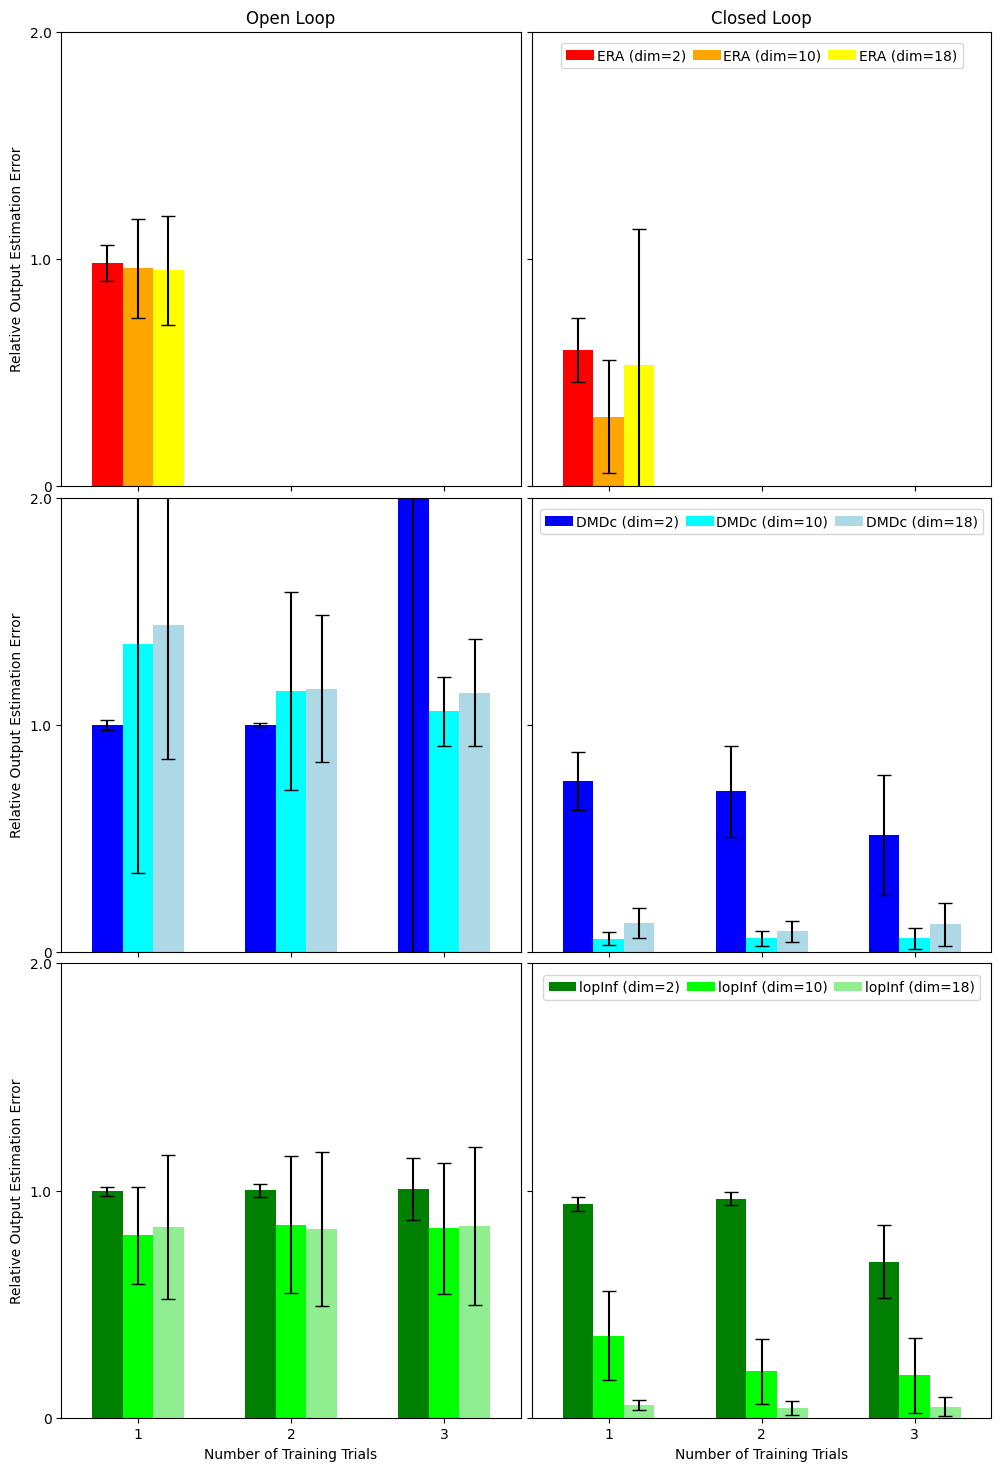

In [18]:
# Plot errors of open/closed loop for models of dimension 2, 12, and 18 as bar plots with error bars
fig, ax = plt.subplots(3, 2, figsize=(12, 18))

width = 0.2  # Width of the bars

# ERA
ax[0, 0].bar(era_OL[era_OL["romDim"] == 2]["numTraining"] - width, era_OL[era_OL["romDim"] == 2]["outputError_mean"], 
             yerr=era_OL[era_OL["romDim"] == 2]["outputError_std"], width=width, label="ERA (dim=2)", color='red', capsize=5)
ax[0, 0].bar(era_OL[era_OL["romDim"] == 10]["numTraining"], era_OL[era_OL["romDim"] == 10]["outputError_mean"], 
             yerr=era_OL[era_OL["romDim"] == 10]["outputError_std"], width=width, label="ERA (dim=10)", color='orange', capsize=5)
ax[0, 0].bar(era_OL[era_OL["romDim"] == 18]["numTraining"] + width, era_OL[era_OL["romDim"] == 18]["outputError_mean"], 
             yerr=era_OL[era_OL["romDim"] == 18]["outputError_std"], width=width, label="ERA (dim=18)", color='yellow', capsize=5)

ax[0, 1].bar(era_CL[era_CL["romDim"] == 2]["numTraining"] - width, era_CL[era_CL["romDim"] == 2]["outputError_mean"], 
             yerr=era_CL[era_CL["romDim"] == 2]["outputError_std"], width=width, label="ERA (dim=2)", color='red', capsize=5)
ax[0, 1].bar(era_CL[era_CL["romDim"] == 10]["numTraining"], era_CL[era_CL["romDim"] == 10]["outputError_mean"], 
             yerr=era_CL[era_CL["romDim"] == 10]["outputError_std"], width=width, label="ERA (dim=10)", color='orange', capsize=5)
ax[0, 1].bar(era_CL[era_CL["romDim"] == 18]["numTraining"] + width, era_CL[era_CL["romDim"] == 18]["outputError_mean"], 
             yerr=era_CL[era_CL["romDim"] == 18]["outputError_std"], width=width, label="ERA (dim=18)", color='yellow', capsize=5)

# DMDc
ax[1, 0].bar(dmdc_OL[dmdc_OL["romDim"] == 2]["numTraining"] - width, dmdc_OL[dmdc_OL["romDim"] == 2]["outputError_mean"], 
             yerr=dmdc_OL[dmdc_OL["romDim"] == 2]["outputError_std"], width=width, label="DMDc (dim=2)", color='blue', capsize=5)
ax[1, 0].bar(dmdc_OL[dmdc_OL["romDim"] == 10]["numTraining"], dmdc_OL[dmdc_OL["romDim"] == 10]["outputError_mean"], 
             yerr=dmdc_OL[dmdc_OL["romDim"] == 10]["outputError_std"], width=width, label="DMDc (dim=10)", color='cyan', capsize=5)
ax[1, 0].bar(dmdc_OL[dmdc_OL["romDim"] == 18]["numTraining"] + width, dmdc_OL[dmdc_OL["romDim"] == 18]["outputError_mean"], 
             yerr=dmdc_OL[dmdc_OL["romDim"] == 18]["outputError_std"], width=width, label="DMDc (dim=18)", color='lightblue', capsize=5)

ax[1, 1].bar(dmdc_CL[dmdc_CL["romDim"] == 2]["numTraining"] - width, dmdc_CL[dmdc_CL["romDim"] == 2]["outputError_mean"], 
             yerr=dmdc_CL[dmdc_CL["romDim"] == 2]["outputError_std"], width=width, label="DMDc (dim=2)", color='blue', capsize=5)
ax[1, 1].bar(dmdc_CL[dmdc_CL["romDim"] == 10]["numTraining"], dmdc_CL[dmdc_CL["romDim"] == 10]["outputError_mean"], 
             yerr=dmdc_CL[dmdc_CL["romDim"] == 10]["outputError_std"], width=width, label="DMDc (dim=10)", color='cyan', capsize=5)
ax[1, 1].bar(dmdc_CL[dmdc_CL["romDim"] == 18]["numTraining"] + width, dmdc_CL[dmdc_CL["romDim"] == 18]["outputError_mean"], 
             yerr=dmdc_CL[dmdc_CL["romDim"] == 18]["outputError_std"], width=width, label="DMDc (dim=18)", color='lightblue', capsize=5)

# lopInf
ax[2, 0].bar(lopinf_OL[lopinf_OL["romDim"] == 2]["numTraining"] - width, lopinf_OL[lopinf_OL["romDim"] == 2]["outputError_mean"], 
             yerr=lopinf_OL[lopinf_OL["romDim"] == 2]["outputError_std"], width=width, label="lopInf (dim=2)", color='green', capsize=5)
ax[2, 0].bar(lopinf_OL[lopinf_OL["romDim"] == 10]["numTraining"], lopinf_OL[lopinf_OL["romDim"] == 10]["outputError_mean"], 
             yerr=lopinf_OL[lopinf_OL["romDim"] == 10]["outputError_std"], width=width, label="lopInf (dim=10)", color='lime', capsize=5)
ax[2, 0].bar(lopinf_OL[lopinf_OL["romDim"] == 18]["numTraining"] + width, lopinf_OL[lopinf_OL["romDim"] == 18]["outputError_mean"], 
             yerr=lopinf_OL[lopinf_OL["romDim"] == 18]["outputError_std"], width=width, label="lopInf (dim=18)", color='lightgreen', capsize=5)

ax[2, 1].bar(lopinf_CL[lopinf_CL["romDim"] == 2]["numTraining"] - width, lopinf_CL[lopinf_CL["romDim"] == 2]["outputError_mean"], 
             yerr=lopinf_CL[lopinf_CL["romDim"] == 2]["outputError_std"], width=width, label="lopInf (dim=2)", color='green', capsize=5)
ax[2, 1].bar(lopinf_CL[lopinf_CL["romDim"] == 10]["numTraining"], lopinf_CL[lopinf_CL["romDim"] == 10]["outputError_mean"], 
             yerr=lopinf_CL[lopinf_CL["romDim"] == 10]["outputError_std"], width=width, label="lopInf (dim=10)", color='lime', capsize=5)
ax[2, 1].bar(lopinf_CL[lopinf_CL["romDim"] == 18]["numTraining"] + width, lopinf_CL[lopinf_CL["romDim"] == 18]["outputError_mean"], 
             yerr=lopinf_CL[lopinf_CL["romDim"] == 18]["outputError_std"], width=width, label="lopInf (dim=18)", color='lightgreen', capsize=5)

for i in range(3):
    for j in range(2):
        ax[i, j].set_ylim([0, 2])
        ax[i, j].set_xlim([0.5, 3.5])
        ax[i, j].set_xticks([1, 2, 3])
        ax[i, j].set_xticklabels(["1", "2", "3"] if i == 2 else [])
        ax[i, j].set_yticks([0, 1.0, 2.0])
        ax[i, j].set_yticklabels([0, 1.0, 2.0] if j == 0 else [])
        if i == 2:
            ax[i, j].set_xlabel("Number of Training Trials")
        if j == 0:
            ax[i, j].set_ylabel("Relative Output Estimation Error")
        if j == 1:
            ax[i, j].legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, fontsize=10, frameon=True, handletextpad=0.2, columnspacing=0.5)
# Set titles only for the topmost plots
ax[0, 0].set_title("Open Loop")
ax[0, 1].set_title("Closed Loop")
# Reduce vertical whitespace between plots
fig.subplots_adjust(hspace=0.025)
fig.subplots_adjust(wspace=0.025)

# Save svg
plt.savefig(visualizationDir + "outputEstimationErrors_trialGroups.svg", format='svg', dpi=1200)

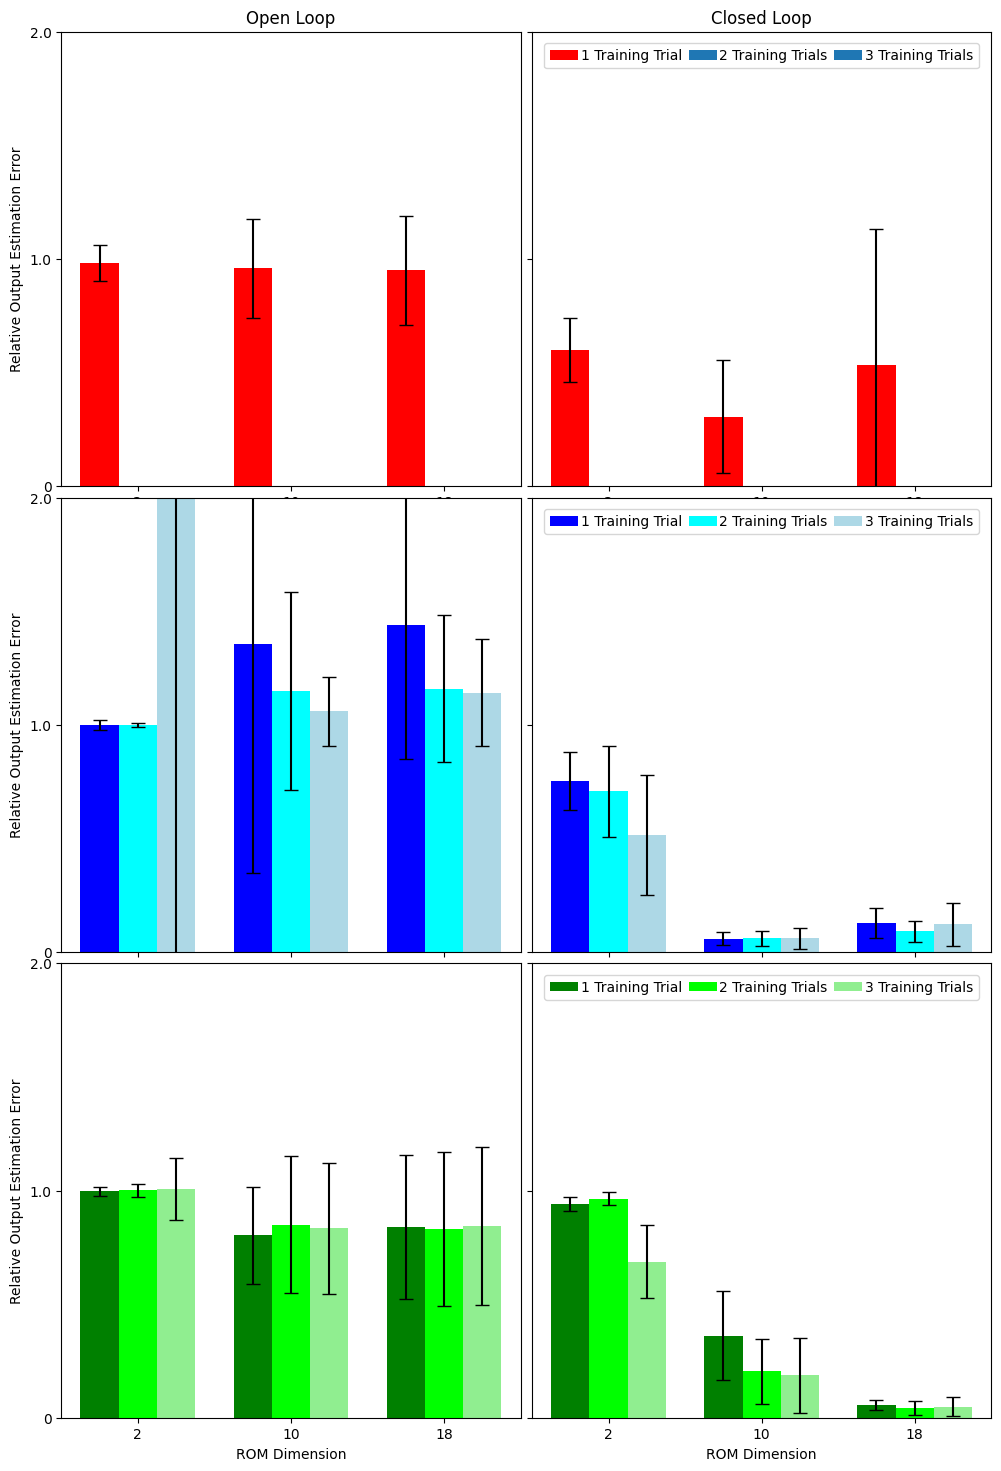

In [19]:
# Plot errors of open/closed loop for models of dimension 2, 10, and 18 as bar plots with error bars
fig, ax = plt.subplots(3, 2, figsize=(12, 18))

width = 2  # Increased width for thicker bars

# ERA - open loop
df = era_OL[(era_OL["romDim"].isin([2, 10, 18])) & (era_OL["numTraining"] == 1)]
ax[0, 0].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='red', capsize=5)
df = era_OL[(era_OL["romDim"].isin([2, 10, 18])) & (era_OL["numTraining"] == 2)]
ax[0, 0].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='orange', capsize=5)
df = era_OL[(era_OL["romDim"].isin([2, 10, 18])) & (era_OL["numTraining"] == 3)]
ax[0, 0].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='yellow', capsize=5)

# ERA - closed loop
df = era_CL[(era_CL["romDim"].isin([2, 10, 18])) & (era_CL["numTraining"] == 1)]
ax[0, 1].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='red', capsize=5)
df = era_CL[(era_CL["romDim"].isin([2, 10, 18])) & (era_CL["numTraining"] == 2)]
ax[0, 1].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='orange', capsize=5)
df = era_CL[(era_CL["romDim"].isin([2, 10, 18])) & (era_CL["numTraining"] == 3)]
ax[0, 1].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='yellow', capsize=5)

# DMDc - open loop
df = dmdc_OL[(dmdc_OL["romDim"].isin([2, 10, 18])) & (dmdc_OL["numTraining"] == 1)]
ax[1, 0].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='blue', capsize=5)
df = dmdc_OL[(dmdc_OL["romDim"].isin([2, 10, 18])) & (dmdc_OL["numTraining"] == 2)]
ax[1, 0].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='cyan', capsize=5)
df = dmdc_OL[(dmdc_OL["romDim"].isin([2, 10, 18])) & (dmdc_OL["numTraining"] == 3)]
ax[1, 0].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightblue', capsize=5)

# DMDc - closed loop
df = dmdc_CL[(dmdc_CL["romDim"].isin([2, 10, 18])) & (dmdc_CL["numTraining"] == 1)]
ax[1, 1].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='blue', capsize=5)
df = dmdc_CL[(dmdc_CL["romDim"].isin([2, 10, 18])) & (dmdc_CL["numTraining"] == 2)]
ax[1, 1].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='cyan', capsize=5)
df = dmdc_CL[(dmdc_CL["romDim"].isin([2, 10, 18])) & (dmdc_CL["numTraining"] == 3)]
ax[1, 1].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightblue', capsize=5)

# lopInf - open loop
df = lopinf_OL[(lopinf_OL["romDim"].isin([2, 10, 18])) & (lopinf_OL["numTraining"] == 1)]
ax[2, 0].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='green', capsize=5)
df = lopinf_OL[(lopinf_OL["romDim"].isin([2, 10, 18])) & (lopinf_OL["numTraining"] == 2)]
ax[2, 0].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='lime', capsize=5)
df = lopinf_OL[(lopinf_OL["romDim"].isin([2, 10, 18])) & (lopinf_OL["numTraining"] == 3)]
ax[2, 0].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightgreen', capsize=5)

# lopInf - closed loop
df = lopinf_CL[(lopinf_CL["romDim"].isin([2, 10, 18])) & (lopinf_CL["numTraining"] == 1)]
ax[2, 1].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='green', capsize=5)
df = lopinf_CL[(lopinf_CL["romDim"].isin([2, 10, 18])) & (lopinf_CL["numTraining"] == 2)]
ax[2, 1].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='lime', capsize=5)
df = lopinf_CL[(lopinf_CL["romDim"].isin([2, 10, 18])) & (lopinf_CL["numTraining"] == 3)]
ax[2, 1].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightgreen', capsize=5)

for i in range(3):
    for j in range(2):
        ax[i, j].set_ylim([0, 2])
        ax[i, j].set_xlim([-2, 22])
        ax[i, j].set_xticks([2, 10, 18])
        ax[i, j].set_yticks([0, 1.0, 2.0])
        ax[i, j].set_yticklabels([0, 1.0, 2.0] if j == 0 else [])

        if i == 2:
            ax[i, j].set_xlabel("ROM Dimension")
        if j == 0:
            ax[i, j].set_ylabel("Relative Output Estimation Error")
        if j == 1:
            ax[i, j].legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, fontsize=10, frameon=True, handletextpad=0.2, columnspacing=0.5)

ax[0, 0].set_title("Open Loop")
ax[0, 1].set_title("Closed Loop")
fig.subplots_adjust(hspace=0.025, wspace=0.025)

plt.savefig(visualizationDir + "outputEstimationErrors_dimGroups.svg", format='svg', dpi=1200)

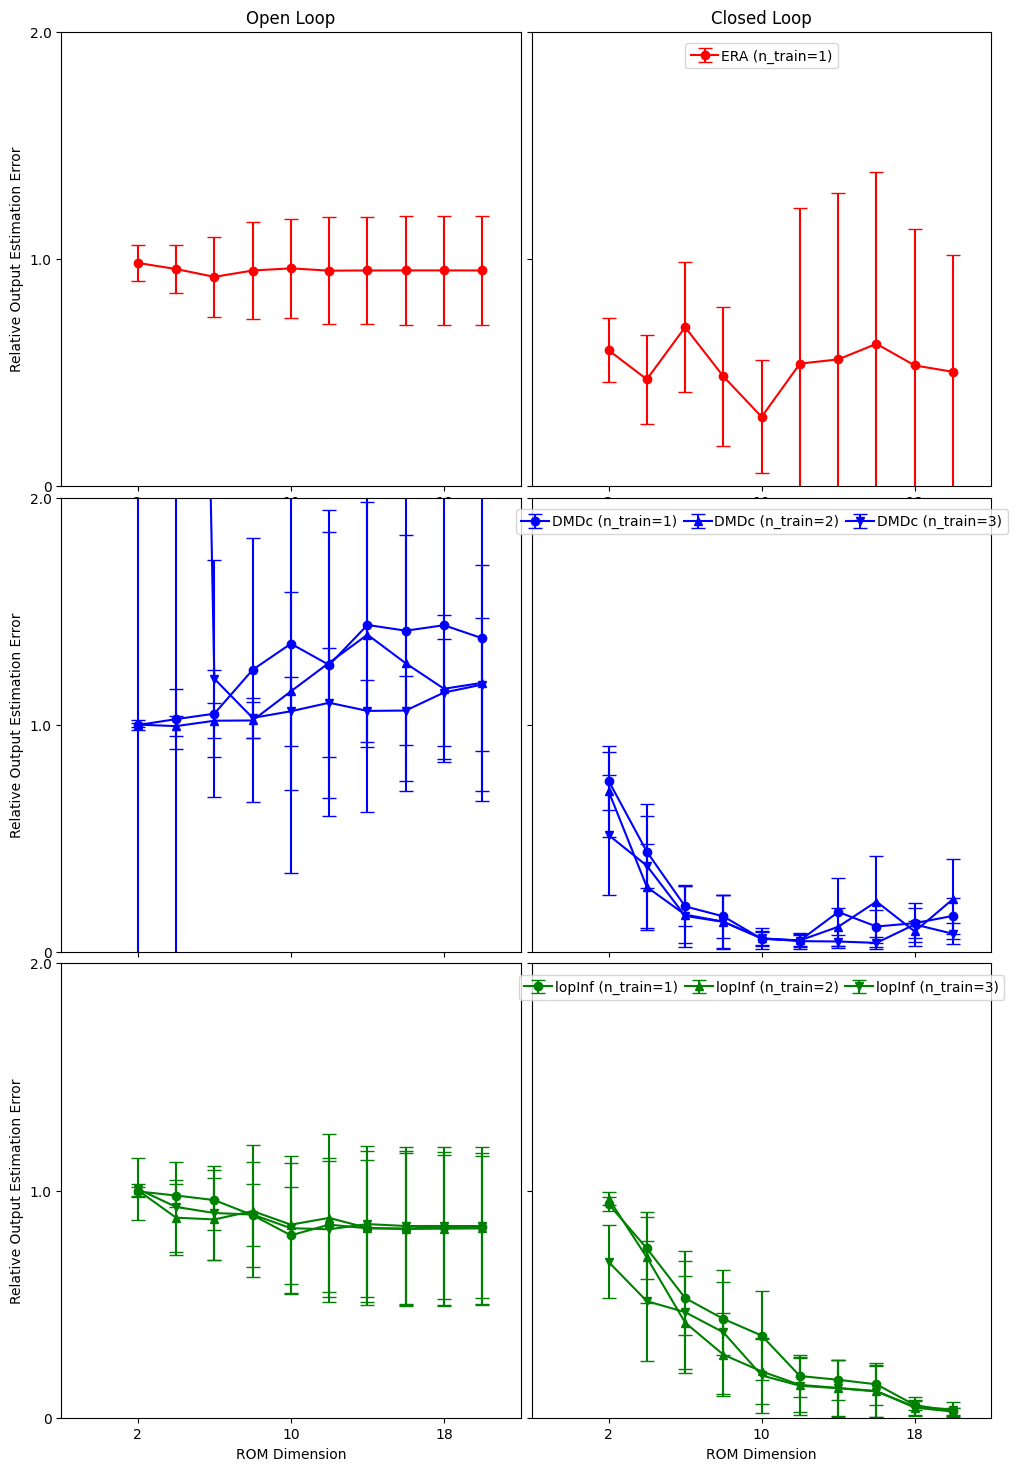

In [20]:
# Plot average prediction errors as a function of rom dimension with error bars
fig, ax = plt.subplots(3,2, figsize=(12, 18))
ax[0,0].errorbar(era_OL[era_OL["numTraining"] == 1]["romDim"], era_OL[era_OL["numTraining"] == 1]["outputError_mean"], yerr=era_OL[era_OL["numTraining"] == 1]["outputError_std"], label="ERA (n_train=1)", fmt='-o', capsize=5, color='red')

ax[0,1].errorbar(era_CL[era_CL["numTraining"] == 1]["romDim"], era_CL[era_CL["numTraining"] == 1]["outputError_mean"], yerr=era_CL[era_CL["numTraining"] == 1]["outputError_std"], label="ERA (n_train=1)", fmt='-o', capsize=5, color='red')

ax[1,0].errorbar(dmdc_OL[dmdc_OL["numTraining"] == 1]["romDim"], dmdc_OL[dmdc_OL["numTraining"] == 1]["outputError_mean"], yerr=dmdc_OL[dmdc_OL["numTraining"] == 1]["outputError_std"], label="DMDc (n_train=1)", fmt='-o', capsize=5, color='blue')
ax[1,0].errorbar(dmdc_OL[dmdc_OL["numTraining"] == 2]["romDim"], dmdc_OL[dmdc_OL["numTraining"] == 2]["outputError_mean"], yerr=dmdc_OL[dmdc_OL["numTraining"] == 2]["outputError_std"], label="DMDc (n_train=2)", fmt='-^', capsize=5, color='blue')
ax[1,0].errorbar(dmdc_OL[dmdc_OL["numTraining"] == 3]["romDim"], dmdc_OL[dmdc_OL["numTraining"] == 3]["outputError_mean"], yerr=dmdc_OL[dmdc_OL["numTraining"] == 3]["outputError_std"], label="DMDc (n_train=3)", fmt='-v', capsize=5, color='blue')

ax[1,1].errorbar(dmdc_CL[dmdc_CL["numTraining"] == 1]["romDim"], dmdc_CL[dmdc_CL["numTraining"] == 1]["outputError_mean"], yerr=dmdc_CL[dmdc_CL["numTraining"] == 1]["outputError_std"], label="DMDc (n_train=1)", fmt='-o', capsize=5, color='blue')
ax[1,1].errorbar(dmdc_CL[dmdc_CL["numTraining"] == 2]["romDim"], dmdc_CL[dmdc_CL["numTraining"] == 2]["outputError_mean"], yerr=dmdc_CL[dmdc_CL["numTraining"] == 2]["outputError_std"], label="DMDc (n_train=2)", fmt='-^', capsize=5, color='blue')
ax[1,1].errorbar(dmdc_CL[dmdc_CL["numTraining"] == 3]["romDim"], dmdc_CL[dmdc_CL["numTraining"] == 3]["outputError_mean"], yerr=dmdc_CL[dmdc_CL["numTraining"] == 3]["outputError_std"], label="DMDc (n_train=3)", fmt='-v', capsize=5, color='blue')

ax[2,0].errorbar(lopinf_OL[lopinf_OL["numTraining"] == 1]["romDim"], lopinf_OL[lopinf_OL["numTraining"] == 1]["outputError_mean"], yerr=lopinf_OL[lopinf_OL["numTraining"] == 1]["outputError_std"], label="lopInf (n_train=1)", fmt='-o', capsize=5, color='green')
ax[2,0].errorbar(lopinf_OL[lopinf_OL["numTraining"] == 2]["romDim"], lopinf_OL[lopinf_OL["numTraining"] == 2]["outputError_mean"], yerr=lopinf_OL[lopinf_OL["numTraining"] == 2]["outputError_std"], label="lopInf (n_train=2)", fmt='-^', capsize=5, color='green')
ax[2,0].errorbar(lopinf_OL[lopinf_OL["numTraining"] == 3]["romDim"], lopinf_OL[lopinf_OL["numTraining"] == 3]["outputError_mean"], yerr=lopinf_OL[lopinf_OL["numTraining"] == 3]["outputError_std"], label="lopInf (n_train=3)", fmt='-v', capsize=5, color='green')

ax[2,1].errorbar(lopinf_CL[lopinf_CL["numTraining"] == 1]["romDim"], lopinf_CL[lopinf_CL["numTraining"] == 1]["outputError_mean"], yerr=lopinf_CL[lopinf_CL["numTraining"] == 1]["outputError_std"], label="lopInf (n_train=1)", fmt='-o', capsize=5, color='green')
ax[2,1].errorbar(lopinf_CL[lopinf_CL["numTraining"] == 2]["romDim"], lopinf_CL[lopinf_CL["numTraining"] == 2]["outputError_mean"], yerr=lopinf_CL[lopinf_CL["numTraining"] == 2]["outputError_std"], label="lopInf (n_train=2)", fmt='-^', capsize=5, color='green')
ax[2,1].errorbar(lopinf_CL[lopinf_CL["numTraining"] == 3]["romDim"], lopinf_CL[lopinf_CL["numTraining"] == 3]["outputError_mean"], yerr=lopinf_CL[lopinf_CL["numTraining"] == 3]["outputError_std"], label="lopInf (n_train=3)", fmt='-v', capsize=5, color='green')

for i in range(3):
    for j in range(2):
        ax[i, j].set_ylim([0, 2])
        ax[i, j].set_xlim([-2, 22])
        ax[i, j].set_xticks([2, 10, 18])
        ax[i, j].set_yticks([0, 1.0, 2.0])
        ax[i, j].set_yticklabels([0, 1.0, 2.0] if j == 0 else [])

        if i == 2:
            ax[i, j].set_xlabel("ROM Dimension")
        if j == 0:
            ax[i, j].set_ylabel("Relative Output Estimation Error")
        if j == 1:
            ax[i, j].legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, fontsize=10, frameon=True, handletextpad=0.2, columnspacing=0.5)

ax[0, 0].set_title("Open Loop")
ax[0, 1].set_title("Closed Loop")
fig.subplots_adjust(hspace=0.025, wspace=0.025)

# save as svg
plt.savefig(visualizationDir + "outputEstimationErrors_dim.svg", format='svg', dpi=1200)


Plot errors as function of input frequency


In [21]:
# Pull errors for each model type

# ERA
era_freq_OL = errors[(errors["romType"] == "ERA") & (errors["OL"] == True) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]
era_freq_CL = errors[(errors["romType"] == "ERA") & (errors["OL"] == False) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]
# DMDc
dmdc_freq_OL = errors[(errors["romType"] == "DMDc") & (errors["OL"] == True) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]
dmdc_freq_CL = errors[(errors["romType"] == "DMDc") & (errors["OL"] == False) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]
# lopInf
lopinf_freq_OL = errors[(errors["romType"] == "lopInf") & (errors["OL"] == True) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]
lopinf_freq_CL = errors[(errors["romType"] == "lopInf") & (errors["OL"] == False) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]


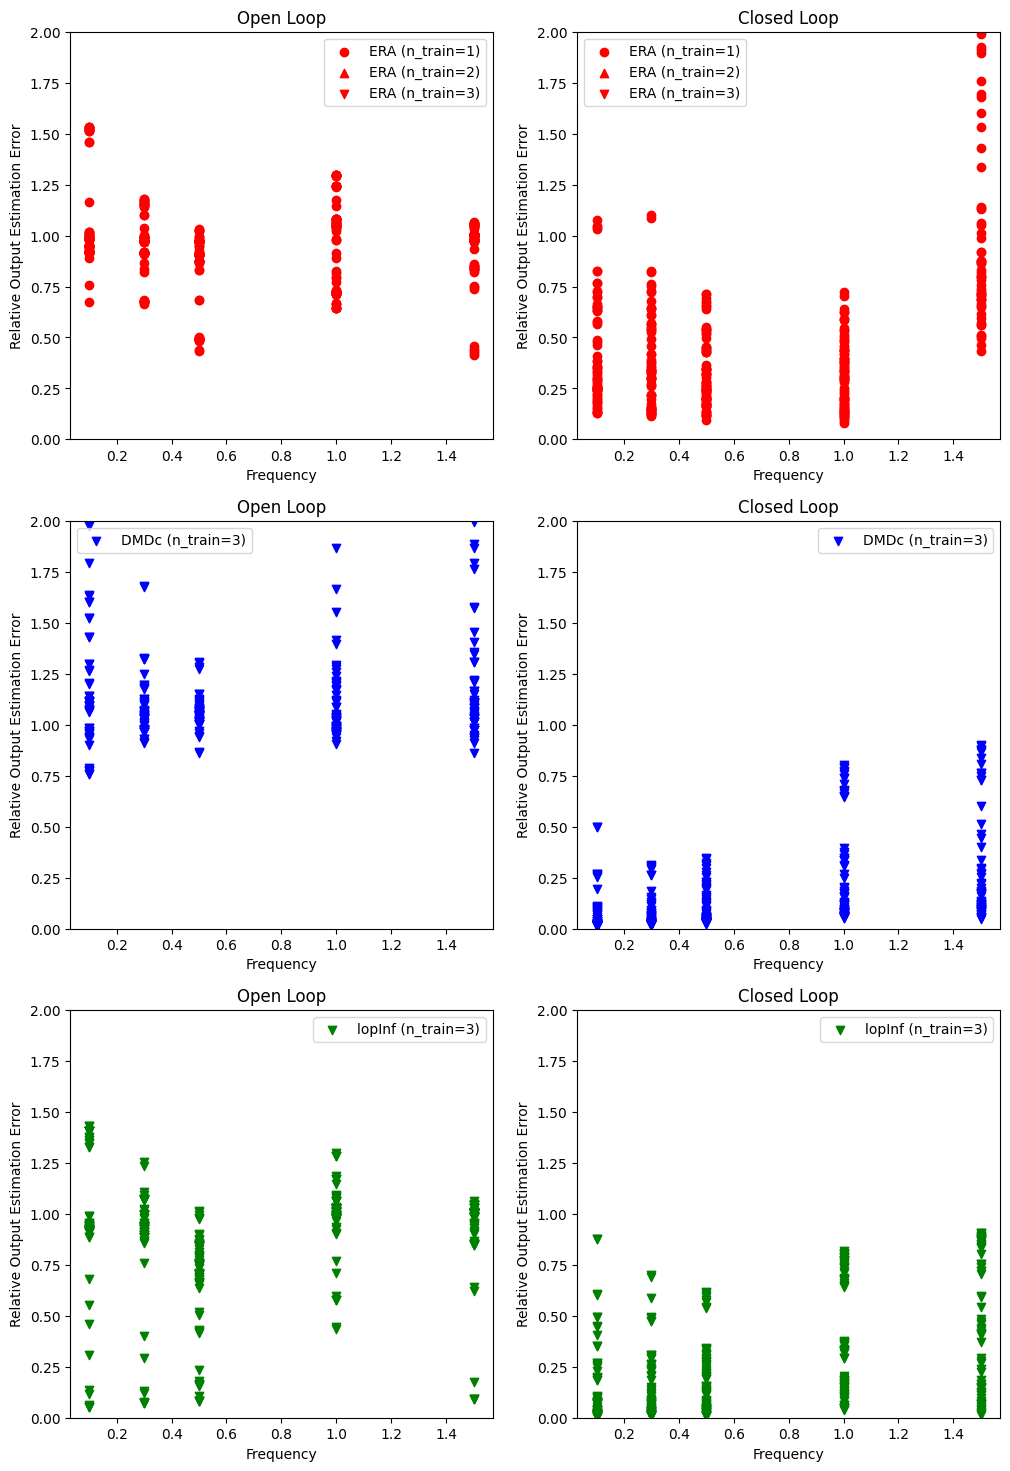

In [22]:
# Scatter plot of the errors for each model type and frequency - different markers for different number of training trials
fig, ax = plt.subplots(3,2, figsize=(12, 18))
ax[0,0].scatter(era_freq_OL[(era_freq_OL["numTraining"]==1) ]["frequency"], era_freq_OL[(era_freq_OL["numTraining"]==1)]["outputError"], label="ERA (n_train=1)", color='red', marker='o')
ax[0,0].scatter(era_freq_OL[(era_freq_OL["numTraining"]==2) ]["frequency"], era_freq_OL[(era_freq_OL["numTraining"]==2)]["outputError"], label="ERA (n_train=2)", color='red', marker='^')
ax[0,0].scatter(era_freq_OL[(era_freq_OL["numTraining"]==3) ]["frequency"], era_freq_OL[(era_freq_OL["numTraining"]==3)]["outputError"], label="ERA (n_train=3)", color='red', marker='v')

ax[0,1].scatter(era_freq_CL[(era_freq_CL["numTraining"]==1) ]["frequency"], era_freq_CL[(era_freq_CL["numTraining"]==1)]["outputError"], label="ERA (n_train=1)", color='red', marker='o')
ax[0,1].scatter(era_freq_CL[(era_freq_CL["numTraining"]==2) ]["frequency"], era_freq_CL[(era_freq_CL["numTraining"]==2)]["outputError"], label="ERA (n_train=2)", color='red', marker='^')
ax[0,1].scatter(era_freq_CL[(era_freq_CL["numTraining"]==3) ]["frequency"], era_freq_CL[(era_freq_CL["numTraining"]==3)]["outputError"], label="ERA (n_train=3)", color='red', marker='v')

# ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==1) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==1)]["outputError"], label="DMDc (n_train=1)", color='blue', marker='o')
# ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==2) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==2)]["outputError"], label="DMDc (n_train=2)", color='blue', marker='^')
ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==3) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==3)]["outputError"], label="DMDc (n_train=3)", color='blue', marker='v')

# ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==1) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==1)]["outputError"], label="DMDc (n_train=1)", color='blue', marker='o')
# ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==2) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==2)]["outputError"], label="DMDc (n_train=2)", color='blue', marker='^')
ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==3) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==3)]["outputError"], label="DMDc (n_train=3)", color='blue', marker='v')

# ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==1) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==1)]["outputError"], label="lopInf (n_train=1)", color='green', marker='o')
# ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==2) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==2)]["outputError"], label="lopInf (n_train=2)", color='green', marker='^')
ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==3) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==3)]["outputError"], label="lopInf (n_train=3)", color='green', marker='v')

# ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==1) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==1)]["outputError"], label="lopInf (n_train=1)", color='green', marker='o')
# ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==2) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==2)]["outputError"], label="lopInf (n_train=2)", color='green', marker='^')
ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==3) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==3)]["outputError"], label="lopInf (n_train=3)", color='green', marker='v')

for i in range(3):
    for j in range(2):
        ax[i,j].set_ylim([0, 2])
        ax[i,j].set_xlabel("Frequency")
        ax[i,j].set_ylabel("Relative Output Estimation Error")
        ax[i,j].legend()
        # ax[i,j].grid()
        ax[i,j].set_title("Open Loop" if j == 0 else "Closed Loop")

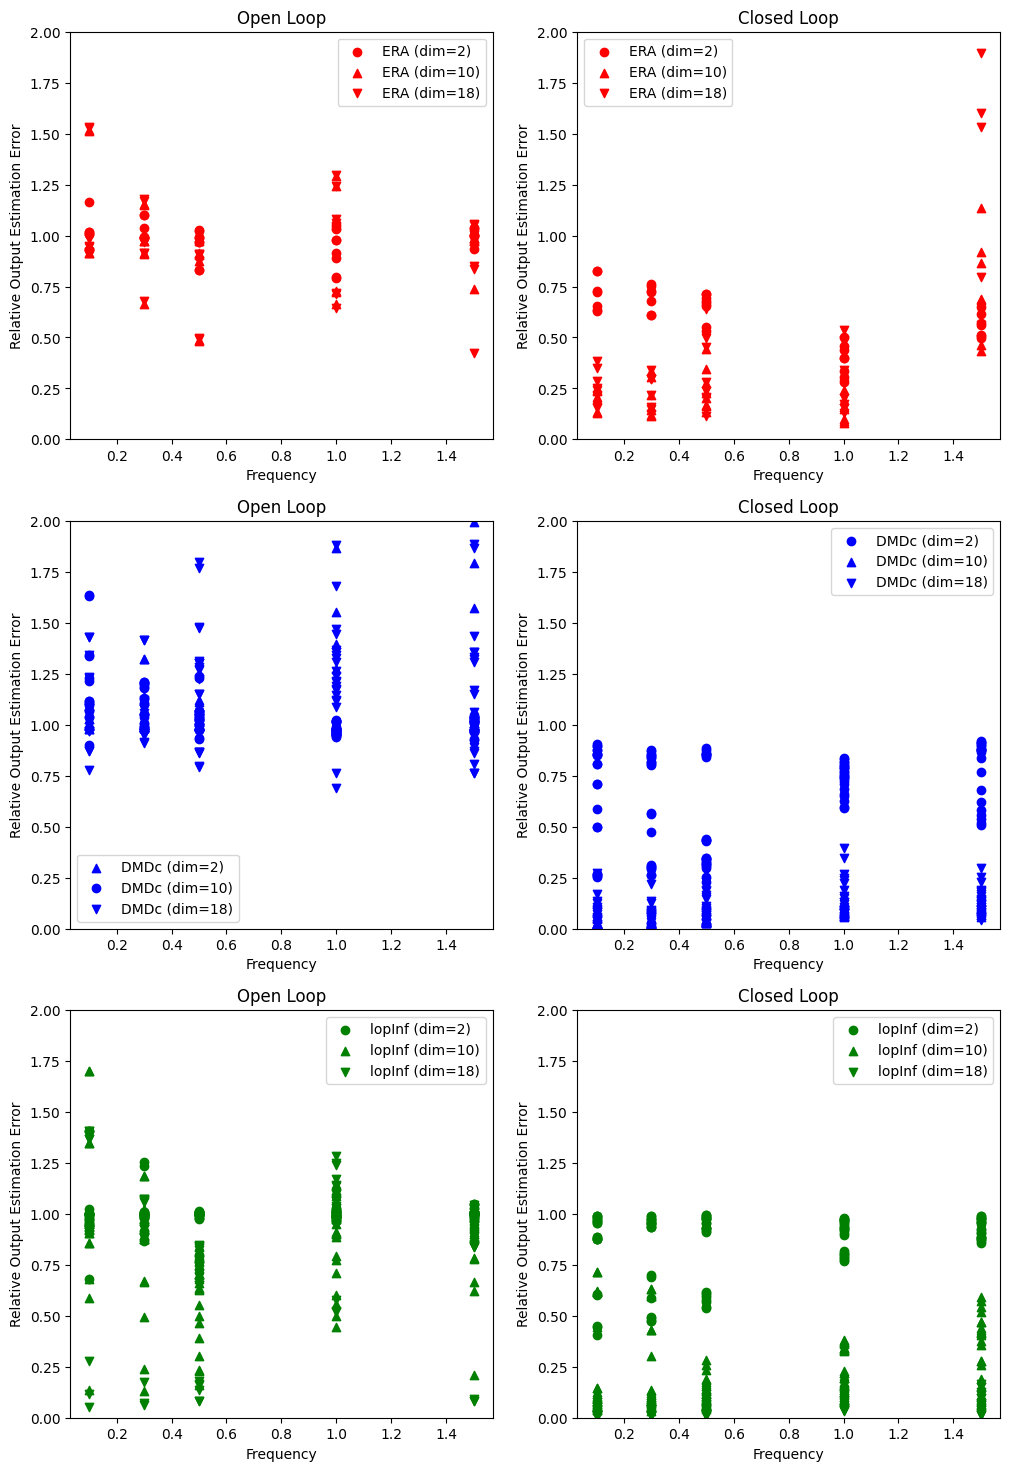

In [23]:
# Scatter plot of the errors for each model type and frequency - different markers for different rom dimensions
fig, ax = plt.subplots(3,2, figsize=(12, 18))
ax[0,0].scatter(era_freq_OL[(era_freq_OL["romDim"]==2) ]["frequency"], era_freq_OL[(era_freq_OL["romDim"]==2)]["outputError"], label="ERA (dim=2)", color='red', marker='o')
ax[0,0].scatter(era_freq_OL[(era_freq_OL["romDim"]==10) ]["frequency"], era_freq_OL[(era_freq_OL["romDim"]==10)]["outputError"], label="ERA (dim=10)", color='red', marker='^')
ax[0,0].scatter(era_freq_OL[(era_freq_OL["romDim"]==18) ]["frequency"], era_freq_OL[(era_freq_OL["romDim"]==18)]["outputError"], label="ERA (dim=18)", color='red', marker='v')

ax[0,1].scatter(era_freq_CL[(era_freq_CL["romDim"]==2) ]["frequency"], era_freq_CL[(era_freq_CL["romDim"]==2)]["outputError"], label="ERA (dim=2)", color='red', marker='o')
ax[0,1].scatter(era_freq_CL[(era_freq_CL["romDim"]==10) ]["frequency"], era_freq_CL[(era_freq_CL["romDim"]==10)]["outputError"], label="ERA (dim=10)", color='red', marker='^')
ax[0,1].scatter(era_freq_CL[(era_freq_CL["romDim"]==18) ]["frequency"], era_freq_CL[(era_freq_CL["romDim"]==18)]["outputError"], label="ERA (dim=18)", color='red', marker='v')

ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["romDim"]==2) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["romDim"]==2)]["outputError"], label="DMDc (dim=2)", color='blue', marker='^')
ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["romDim"]==10) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["romDim"]==10)]["outputError"], label="DMDc (dim=10)", color='blue', marker='o')
ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["romDim"]==18) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["romDim"]==18)]["outputError"], label="DMDc (dim=18)", color='blue', marker='v')

ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["romDim"]==2) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["romDim"]==2)]["outputError"], label="DMDc (dim=2)", color='blue', marker='o')
ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["romDim"]==10) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["romDim"]==10)]["outputError"], label="DMDc (dim=10)", color='blue', marker='^')
ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["romDim"]==18) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["romDim"]==18)]["outputError"], label="DMDc (dim=18)", color='blue', marker='v')

ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["romDim"]==2) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["romDim"]==2)]["outputError"], label="lopInf (dim=2)", color='green', marker='o')
ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["romDim"]==10) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["romDim"]==10)]["outputError"], label="lopInf (dim=10)", color='green', marker='^')
ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["romDim"]==18) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["romDim"]==18)]["outputError"], label="lopInf (dim=18)", color='green', marker='v')

ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["romDim"]==2) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["romDim"]==2)]["outputError"], label="lopInf (dim=2)", color='green', marker='o')
ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["romDim"]==10) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["romDim"]==10)]["outputError"], label="lopInf (dim=10)", color='green', marker='^')
ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["romDim"]==18) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["romDim"]==18)]["outputError"], label="lopInf (dim=18)", color='green', marker='v')

for i in range(3):
    for j in range(2):
        ax[i,j].set_ylim([0, 2])
        ax[i,j].set_xlabel("Frequency")
        ax[i,j].set_ylabel("Relative Output Estimation Error")
        ax[i,j].legend()
        # ax[i,j].grid()
        ax[i,j].set_title("Open Loop" if j == 0 else "Closed Loop")

# Control Experiments

## Helper function to read in data

In [24]:
# Helper functions for working with database
def get_db_connection():
    conn = psycopg2.connect(
        dbname='simDB',
        user='user',
        password='password',
        host='localhost',
        port='5432'
    )
    return conn

def fetch_trial_data(conn, trial_id,n=1,limit=500):
    try:
        cur = conn.cursor()
        
        # Fetch data for the given trial_id
        query = '''
        SELECT timestep, simulation_time, input_data, output_data, y_ref, x_hat
        FROM simulation_data
        WHERE trial_id = %s AND MOD(timestep, %s) = 0
        ORDER BY timestep ASC LIMIT %s;
        '''
        cur.execute(query, (trial_id, n, limit))
        rows = cur.fetchall()
        
        # Deserialize data
        data = []
        for row in rows:
            timestep, simulation_time, input_data_bin, output_data_bin, y_ref_bin, x_hat_bin = row
            input_data = np.array(pickle.loads(input_data_bin)).flatten()
            output_data = np.array(pickle.loads(output_data_bin)).flatten()
            y_ref = np.array(pickle.loads(y_ref_bin)).flatten()
            x_hat = np.array(pickle.loads(x_hat_bin)).flatten()
            data.append((timestep, simulation_time, input_data, output_data, y_ref, x_hat))
        
        cur.close()
        return data
    except Exception as e:
        print(f"Error fetching data for trial_id {trial_id}: {e}")
        return None

## Feasible Trajectory Tracking - Equal Tracking Weights Across Body

In [25]:
# Trial Parameters

lopinf_trial_ids_train = [214,233,237]
lopinf_trial_ids_test = [198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236]
dmdc_trial_ids_train = [291, 267] # 287]# 267]
dmdc_trial_ids_test = [337, 250, 251, 252, 253, 254, 255, 256, 257, 260, 261, 262, 263, 264, 265, 266, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 286, 288, 289, 290]
era_trial_ids_train = [335]# 267]
era_trial_ids_test = [293, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 330, 331, 332, 333, 334, 335]

trial_id = lopinf_trial_ids_train[0]
timesteps = 500
n = 1


In [26]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")


OutputDim: 40, InputDim: 6, x_hatDim: 18


In [27]:
# Initialize array to hold relative errors over all trials 
lopinf_rel_errors_avg_train = np.zeros((20, len(lopinf_trial_ids_train)))
lopinf_rel_errors_avg_test = np.zeros((20, len(lopinf_trial_ids_test)))
dmdc_rel_errors_avg_train = np.zeros((20, len(dmdc_trial_ids_train)))
dmdc_rel_errors_avg_test = np.zeros((20, len(dmdc_trial_ids_test)))
era_rel_errors_avg_train = np.zeros((20, len(era_trial_ids_train)))
era_rel_errors_avg_test = np.zeros((20, len(era_trial_ids_test)))
### Calculate statistics for LOpInf
# Compute relative errors for each training trial
for trialInd in range(len(lopinf_trial_ids_train)):
    trial_id = lopinf_trial_ids_train[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)

# Compute relative errors for each test trial
for trialInd in range(len(lopinf_trial_ids_test)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_lopinf = np.mean(lopinf_rel_errors_avg_train, axis=1)
std_errors_train_lopinf = np.std(lopinf_rel_errors_avg_train, axis=1)
mean_errors_test_lopinf = np.mean(lopinf_rel_errors_avg_test, axis=1)
std_errors_test_lopinf = np.std(lopinf_rel_errors_avg_test, axis=1)

### Calculate statistics for DMDc
# Compute relative errors for each training trial
for trialInd in range(len(dmdc_trial_ids_train)):
    trial_id = dmdc_trial_ids_train[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial
for trialInd in range(len(dmdc_trial_ids_test)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_dmdc = np.mean(dmdc_rel_errors_avg_train, axis=1)
std_errors_train_dmdc = np.std(dmdc_rel_errors_avg_train, axis=1)
mean_errors_test_dmdc = np.mean(dmdc_rel_errors_avg_test, axis=1)
std_errors_test_dmdc = np.std(dmdc_rel_errors_avg_test, axis=1)

### Calculate statistics for ERA
# Compute relative errors for each training trial
for trialInd in range(len(era_trial_ids_train)):
    trial_id = era_trial_ids_train[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial
for trialInd in range(len(era_trial_ids_test)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_era = np.mean(era_rel_errors_avg_train, axis=1)
std_errors_train_era = np.std(era_rel_errors_avg_train, axis=1)
mean_errors_test_era = np.mean(era_rel_errors_avg_test, axis=1)
std_errors_test_era = np.std(era_rel_errors_avg_test, axis=1)


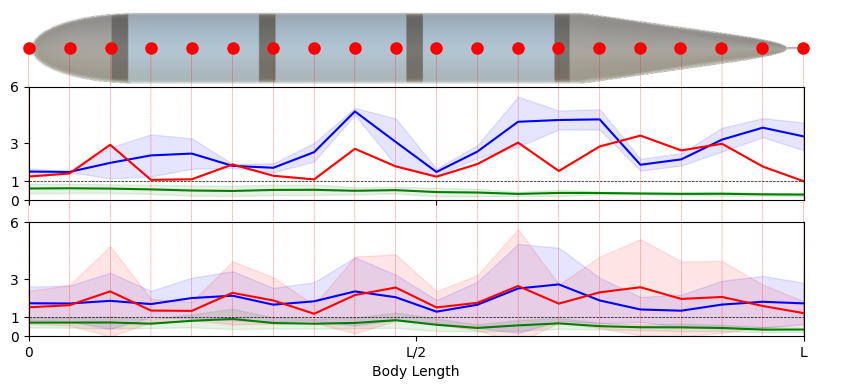

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(10, 5))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all training trials with shaded region indicating standard deviation
ax[1].plot(mean_errors_train_lopinf, label="LOpInf", color='green')
ax[1].fill_between(range(len(mean_errors_train_lopinf)), mean_errors_train_lopinf - std_errors_train_lopinf, mean_errors_train_lopinf + std_errors_train_lopinf, color='green', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_train_dmdc, label="DMDc", color='blue')
ax[1].fill_between(range(len(mean_errors_train_dmdc)), mean_errors_train_dmdc - std_errors_train_dmdc, mean_errors_train_dmdc + std_errors_train_dmdc, color='blue', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_train_era, label="ERA", color='red')
ax[1].fill_between(range(len(mean_errors_train_era)), mean_errors_train_era - std_errors_train_era, mean_errors_train_era + std_errors_train_era, color='red', alpha=0.1, label="Standard Deviation")
ax[1].set_xticks([0, 10, 20])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Plot tracking errors over all test trials with shaded region indicating standard deviation
ax[2].plot(mean_errors_test_lopinf, label="LOpInf", color='green')
ax[2].fill_between(range(len(mean_errors_test_lopinf)), mean_errors_test_lopinf - std_errors_test_lopinf, mean_errors_test_lopinf + std_errors_test_lopinf, color='green', alpha=0.1, label="Standard Deviation")
ax[2].plot(mean_errors_test_dmdc, label="DMDc", color='blue')
ax[2].fill_between(range(len(mean_errors_test_dmdc)), mean_errors_test_dmdc - std_errors_test_dmdc, mean_errors_test_dmdc + std_errors_test_dmdc, color='blue', alpha=0.1, label="Standard Deviation")
ax[2].plot(mean_errors_test_era, label="ERA", color='red')
ax[2].fill_between(range(len(mean_errors_test_era)), mean_errors_test_era - std_errors_test_era, mean_errors_test_era + std_errors_test_era, color='red', alpha=0.1, label="Standard Deviation")
ax[2].set_xlabel("Body Length")
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels(["0", "L/2", "L"])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6.0])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# # Add a single y-axis label across the center of the bottom two subplots
# fig.text(0.04, 0.35, "Average Relative Error", va='center', rotation='vertical')

# Save svg
# plt.savefig(visualizationDir + "outputTrackingErrors_Spatial.svg", format='svg', dpi=1200)
ax[0].set_position([0.119, 0.555, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot to the halfway up the first subplot
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[2], color="red", linestyle='--', linewidth=0.2)
    ax[2].add_artist(con)


# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_feasibleEqual.svg", format='svg', dpi=1200)
# # Save as png
# plt.savefig(visualizationDir + "outputTrackingErrors_Spatial.png", format='png', dpi=1200)


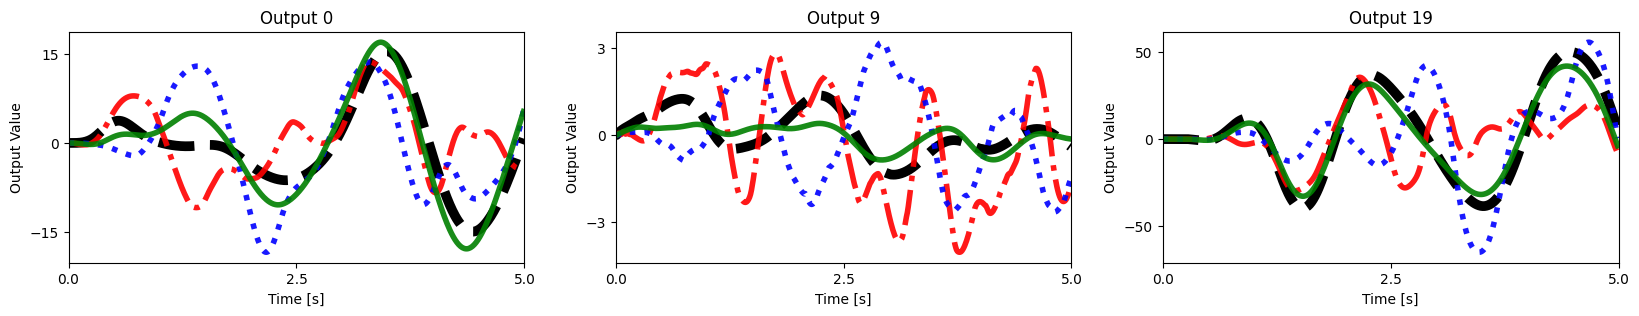

In [29]:
# Plot timeseries trajectories of references and outputs for a given trial with all three MPC models
test_trials_era = [293, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 330, 331, 332, 333, 334, 335]
test_trials_dmdc = [337, 250, 251, 252, 253, 254, 255, 256, 257, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 286, 287, 288, 289, 290, 291]
test_trials_lopinf = [198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237]
# Output indices to plot
output_indices = [39, 21, 1] # Descdending order of output indices so tail is on the right
# Define the trial to plot
trial_id = 37
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
# Read in ERA data
conn = get_db_connection()
data = fetch_trial_data(conn, test_trials_era[trial_id], n, 500)
conn.close()
simulation_timesteps_era = np.array([row[0] for row in data])
simulation_times_era = np.array([row[1] for row in data])
input_data_era = np.array([row[2] for row in data]).T
output_data_era = np.array([row[3] for row in data]).T
y_refs_era = np.array([row[4] for row in data]).T
x_hats_era = np.array([row[5] for row in data]).T
# Read data to numpy arrays
Y_fom_era = output_data_era
U_fom_era = input_data_era
Y0_fom_era = Y_fom_era[:,0]
# Center Y_fom about neutral position
Y_fom_era = Y_fom_era-Y0_fom_era[:,np.newaxis]
# Read in DMDc data
conn = get_db_connection()
data = fetch_trial_data(conn, test_trials_dmdc[trial_id], n, 500)
conn.close()
simulation_timesteps_dmdc = np.array([row[0] for row in data])
simulation_times_dmdc = np.array([row[1] for row in data])
input_data_dmdc = np.array([row[2] for row in data]).T
output_data_dmdc = np.array([row[3] for row in data]).T
y_refs_dmdc = np.array([row[4] for row in data]).T
x_hats_dmdc = np.array([row[5] for row in data]).T
# Read data to numpy arrays
Y_fom_dmdc = output_data_dmdc
U_fom_dmdc = input_data_dmdc
Y0_fom_dmdc = Y_fom_dmdc[:,0]
# Center Y_fom about neutral position
Y_fom_dmdc = Y_fom_dmdc-Y0_fom_dmdc[:,np.newaxis]
# Read in LOpInf data
conn = get_db_connection()
data = fetch_trial_data(conn, test_trials_lopinf[trial_id], n, 500)
conn.close()
simulation_timesteps_lopinf = np.array([row[0] for row in data])
simulation_times_lopinf = np.array([row[1] for row in data])
input_data_lopinf = np.array([row[2] for row in data]).T
output_data_lopinf = np.array([row[3] for row in data]).T
y_refs_lopinf = np.array([row[4] for row in data]).T
x_hats_lopinf = np.array([row[5] for row in data]).T
# Read data to numpy arrays
Y_fom_lopinf = output_data_lopinf
U_fom_lopinf = input_data_lopinf
Y0_fom_lopinf = Y_fom_lopinf[:,0]
# Center Y_fom about neutral position
Y_fom_lopinf = Y_fom_lopinf-Y0_fom_lopinf[:,np.newaxis]


# Plot the references and outputs for each model type at the specified output indices
simulation_times = simulation_times_era  # All models have the same time vector  
for i, output_index in enumerate(output_indices):
    # Plot ERA
    ax[i].plot(simulation_times, y_refs_era[output_index, :], label="Reference (ERA)", color='black', linestyle='--', linewidth=7)
    ax[i].plot(simulation_times, Y_fom_era[output_index, :], label="Output (ERA)", color='red', linewidth=4, linestyle='-.', alpha=0.9)
    # Plot DMDc
    ax[i].plot(simulation_times, Y_fom_dmdc[output_index, :], label="Output (DMDc)", color='blue', linewidth=4,linestyle=':' , alpha=0.9)
    # Plot LOpInf
    ax[i].plot(simulation_times, Y_fom_lopinf[output_index, :], label="Output (LOpInf)", color='green', linewidth=4,linestyle='-', alpha=0.9)
    

    # Set titles and labels
    ax[i].set_title(f"Output {19-(output_index-1)//2}")
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Output Value")
    ax[i].set_xlim([0, 5])
    ax[i].set_xticks([0, 2.5, 5])
    # Set only 3 y-ticks but make them adaptive to the plot range based on reference
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(3))
    

# Save as svg
plt.savefig(visualizationDir + "outputTrajectories_feasibleEqual_trial_" + str(trial_id) + ".svg", format='svg', dpi=1200)

## Feasible Trajectory Tracking - Moderately Tail-focused Weights Across Body

In [30]:
# Trial Parameters

lopinf_trial_ids_train_equal = [214, 233, 237]
lopinf_trial_ids_train_tail = [360, 352, 358] 
lopinf_trial_ids_test_equal = [201, 203, 209, 216, 219, 223, 230, 236] 
lopinf_trial_ids_test_tail = [349, 350, 351, 353, 355, 356, 357, 359]
dmdc_trial_ids_train_equal = [291, 267] 
dmdc_trial_ids_train_tail = [348,341] 
dmdc_trial_ids_test_equal = [252, 254, 262, 269, 272, 276, 283, 290]
dmdc_trial_ids_test_tail = [338, 339, 340, 342, 343, 344, 345, 347]
era_trial_ids_train_equal = [335]
era_trial_ids_train_tail = [335]#[372]
era_trial_ids_test_equal = [297, 299, 305, 311, 313, 316, 320, 327, 331, 334]
era_trial_ids_test_tail = [362, 363, 364, 365, 366, 367, 368, 369, 370, 371]

trial_id = lopinf_trial_ids_train_equal[0]
timesteps = 500
n = 1

In [31]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

OutputDim: 40, InputDim: 6, x_hatDim: 18


### Relative Error Over Body Length 

#### Training Data Trials

In [32]:
# Initialize array to hold relative errors over all trials 
lopinf_rel_errors_avg_train_equal = np.zeros((20, len(lopinf_trial_ids_train_equal)))
lopinf_rel_errors_avg_train_tail = np.zeros((20, len(lopinf_trial_ids_train_tail)))
lopinf_rel_errors_avg_test_equal = np.zeros((20, len(lopinf_trial_ids_test_equal)))
lopinf_rel_errors_avg_test_tail = np.zeros((20, len(lopinf_trial_ids_test_tail)))
dmdc_rel_errors_avg_train_equal = np.zeros((20, len(dmdc_trial_ids_train_equal)))
dmdc_rel_errors_avg_train_tail = np.zeros((20, len(dmdc_trial_ids_train_tail)))
dmdc_rel_errors_avg_test_equal = np.zeros((20, len(dmdc_trial_ids_test_equal)))
dmdc_rel_errors_avg_test_tail = np.zeros((20, len(dmdc_trial_ids_test_tail)))
era_rel_errors_avg_train_equal = np.zeros((20, len(era_trial_ids_train_equal)))
era_rel_errors_avg_train_tail = np.zeros((20, len(era_trial_ids_train_tail)))
era_rel_errors_avg_test_equal = np.zeros((20, len(era_trial_ids_test_equal)))
era_rel_errors_avg_test_tail = np.zeros((20, len(era_trial_ids_test_tail)))
### Calculate statistics for LOpInf
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(lopinf_trial_ids_train_equal)):
    trial_id = lopinf_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)

# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(lopinf_trial_ids_train_tail)):
    trial_id = lopinf_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)


# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(lopinf_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)

# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(lopinf_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)

mean_errors_train_lopinf_equal = np.mean(lopinf_rel_errors_avg_train_equal, axis=1)
mean_errors_train_lopinf_tail = np.mean(lopinf_rel_errors_avg_train_tail, axis=1)
std_errors_train_lopinf_equal = np.std(lopinf_rel_errors_avg_train_equal, axis=1)
std_errors_train_lopinf_tail = np.std(lopinf_rel_errors_avg_train_tail, axis=1)
mean_errors_test_lopinf_equal = np.mean(lopinf_rel_errors_avg_test_equal, axis=1)
mean_errors_test_lopinf_tail = np.mean(lopinf_rel_errors_avg_test_tail, axis=1)
std_errors_test_lopinf_equal = np.std(lopinf_rel_errors_avg_test_equal, axis=1)
std_errors_test_lopinf_tail = np.std(lopinf_rel_errors_avg_test_tail, axis=1)

### Calculate statistics for DMDc
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(dmdc_trial_ids_train_equal)):
    trial_id = dmdc_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(dmdc_trial_ids_train_tail)):
    trial_id = dmdc_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(dmdc_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(dmdc_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_dmdc_equal = np.mean(dmdc_rel_errors_avg_train_equal, axis=1)
mean_errors_train_dmdc_tail = np.mean(dmdc_rel_errors_avg_train_tail, axis=1)
std_errors_train_dmdc_equal = np.std(dmdc_rel_errors_avg_train_equal, axis=1)
std_errors_train_dmdc_tail = np.std(dmdc_rel_errors_avg_train_tail, axis=1)
mean_errors_test_dmdc_equal = np.mean(dmdc_rel_errors_avg_test_equal, axis=1)
mean_errors_test_dmdc_tail = np.mean(dmdc_rel_errors_avg_test_tail, axis=1)
std_errors_test_dmdc_equal = np.std(dmdc_rel_errors_avg_test_equal, axis=1)
std_errors_test_dmdc_tail = np.std(dmdc_rel_errors_avg_test_tail, axis=1)
### Calculate statistics for ERA
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(era_trial_ids_train_equal)):
    trial_id = era_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(era_trial_ids_train_tail)):
    trial_id = era_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(era_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(era_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_era_equal = np.mean(era_rel_errors_avg_train_equal, axis=1)
mean_errors_train_era_tail = np.mean(era_rel_errors_avg_train_tail, axis=1)
std_errors_train_era_equal = np.std(era_rel_errors_avg_train_equal, axis=1)
std_errors_train_era_tail = np.std(era_rel_errors_avg_train_tail, axis=1)
mean_errors_test_era_equal = np.mean(era_rel_errors_avg_test_equal, axis=1)
mean_errors_test_era_tail = np.mean(era_rel_errors_avg_test_tail, axis=1)
std_errors_test_era_equal = np.std(era_rel_errors_avg_test_equal, axis=1)
std_errors_test_era_tail = np.std(era_rel_errors_avg_test_tail, axis=1)
#


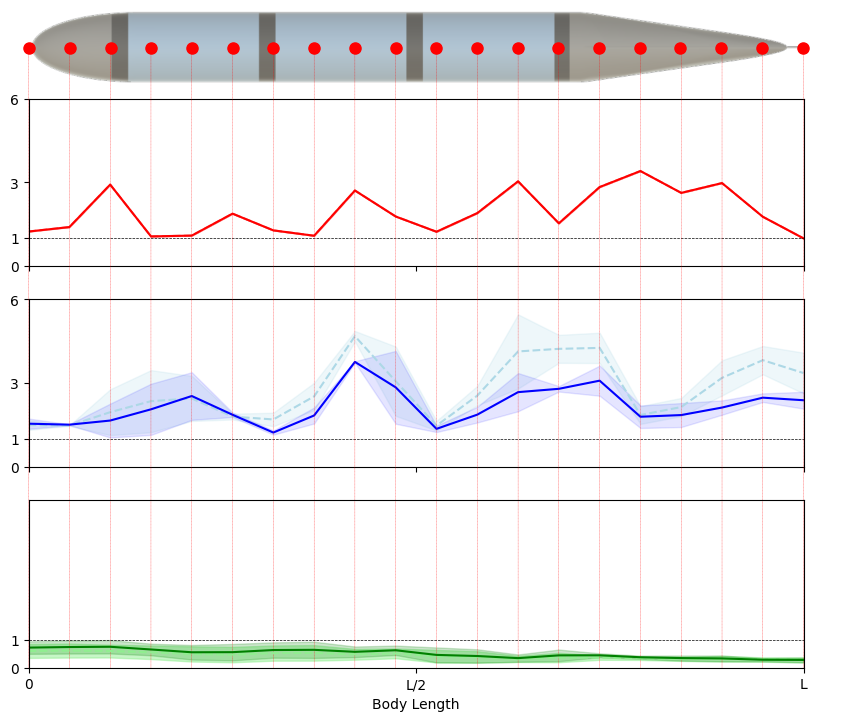

In [33]:
# Plot Training Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all training trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_train_era_equal, label="ERA (Equal Weights)", color='lightcoral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_train_era_equal)), mean_errors_train_era_equal - std_errors_train_era_equal, mean_errors_train_era_equal + std_errors_train_era_equal, color='lightcoral', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_train_era_tail, label="ERA (Tail-Focused Weights)", color='red', linestyle='-')
ax[1].fill_between(range(len(mean_errors_train_era_tail)), mean_errors_train_era_tail - std_errors_train_era_tail, mean_errors_train_era_tail + std_errors_train_era_tail, color='red', alpha=0.2)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_train_dmdc_equal, label="DMDc (Equal Weights)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_train_dmdc_equal)), mean_errors_train_dmdc_equal - std_errors_train_dmdc_equal, mean_errors_train_dmdc_equal + std_errors_train_dmdc_equal, color='lightblue', alpha=0.2, label="Standard Deviation")
ax[2].plot(mean_errors_train_dmdc_tail, label="DMDc (Tail-Focused Weights)", color='blue', linestyle='-')
ax[2].fill_between(range(len(mean_errors_train_dmdc_tail)), mean_errors_train_dmdc_tail - std_errors_train_dmdc_tail, mean_errors_train_dmdc_tail + std_errors_train_dmdc_tail, color='blue', alpha=0.1)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_train_lopinf_equal, label="LOpInf (Equal Weights)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_train_lopinf_equal)), mean_errors_train_lopinf_equal - std_errors_train_lopinf_equal, mean_errors_train_lopinf_equal + std_errors_train_lopinf_equal, color='lightgreen', alpha=0.5, label="Standard Deviation")
ax[3].plot(mean_errors_train_lopinf_tail, label="LOpInf (Tail-Focused Weights)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_train_lopinf_tail)), mean_errors_train_lopinf_tail - std_errors_train_lopinf_tail, mean_errors_train_lopinf_tail + std_errors_train_lopinf_tail, color='green', alpha=0.2)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 6])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_TailFocused_Train.svg", format='svg', dpi=1200)



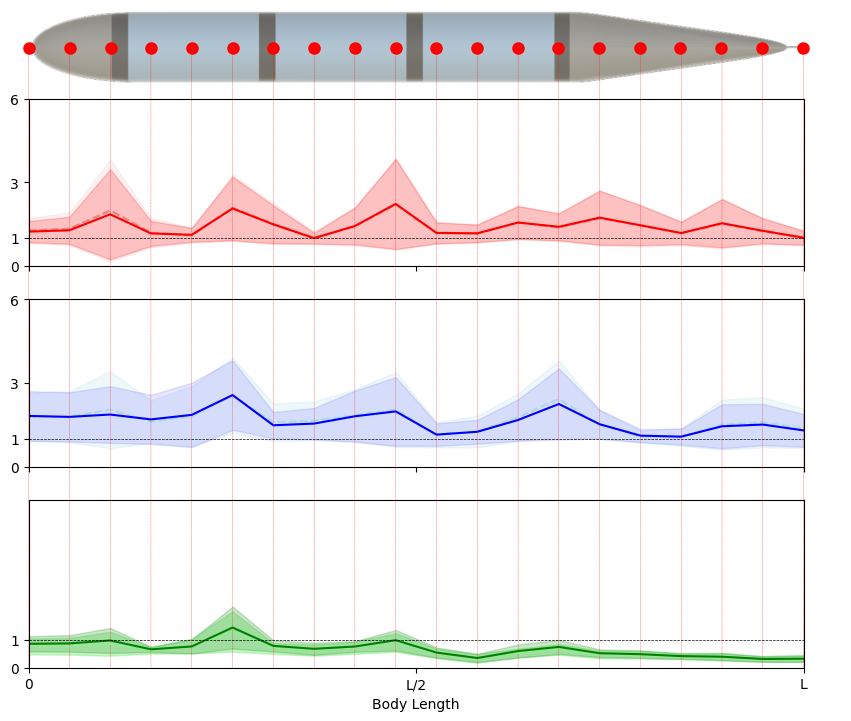

In [34]:
# Plot Test Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all test trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_test_era_equal, label="ERA (Equal Weights)", color='lightcoral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_test_era_equal)), mean_errors_test_era_equal - std_errors_test_era_equal, mean_errors_test_era_equal + std_errors_test_era_equal, color='lightcoral', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_test_era_tail, label="ERA (Tail-Focused Weights)", color='red', linestyle='-')
ax[1].fill_between(range(len(mean_errors_test_era_tail)), mean_errors_test_era_tail - std_errors_test_era_tail, mean_errors_test_era_tail + std_errors_test_era_tail, color='red', alpha=0.2)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_test_dmdc_equal, label="DMDc (Equal Weights)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_test_dmdc_equal)), mean_errors_test_dmdc_equal - std_errors_test_dmdc_equal, mean_errors_test_dmdc_equal + std_errors_test_dmdc_equal, color='lightblue', alpha=0.2, label="Standard Deviation")
ax[2].plot(mean_errors_test_dmdc_tail, label="DMDc (Tail-Focused Weights)", color='blue', linestyle='-')
ax[2].fill_between(range(len(mean_errors_test_dmdc_tail)), mean_errors_test_dmdc_tail - std_errors_test_dmdc_tail, mean_errors_test_dmdc_tail + std_errors_test_dmdc_tail, color='blue', alpha=0.1)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_test_lopinf_equal, label="LOpInf (Equal Weights)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_test_lopinf_equal)), mean_errors_test_lopinf_equal - std_errors_test_lopinf_equal, mean_errors_test_lopinf_equal + std_errors_test_lopinf_equal, color='lightgreen', alpha=0.5, label="Standard Deviation")
ax[3].plot(mean_errors_test_lopinf_tail, label="LOpInf (Tail-Focused Weights)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_test_lopinf_tail)), mean_errors_test_lopinf_tail - std_errors_test_lopinf_tail, mean_errors_test_lopinf_tail + std_errors_test_lopinf_tail, color='green', alpha=0.2)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 6])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_TailFocused_Test.svg", format='svg', dpi=1200)



## Feasible Trajectory Tracking - Heavily Tail-focused Weights Across Body

In [35]:
# Trial Parameters

lopinf_trial_ids_train_equal = [214, 233, 237]
lopinf_trial_ids_train_tail = [419,417,412] 
lopinf_trial_ids_test_equal = [201, 203, 209, 216, 219, 223, 230, 236] 
lopinf_trial_ids_test_tail = [409,410,411,413,414,415,416,418]
dmdc_trial_ids_train_equal = [291, 267] 
dmdc_trial_ids_train_tail = [388,395] 
dmdc_trial_ids_test_equal = [252, 254, 262, 269, 272, 276, 283, 290]
dmdc_trial_ids_test_tail = [385,386,387,389,390,391,392,393,394] 
era_trial_ids_train_equal = [335]
era_trial_ids_train_tail = [335]#[372]
era_trial_ids_test_equal = [297, 299, 305, 311, 313, 316, 320, 327, 331, 334]
era_trial_ids_test_tail = [362, 363, 364, 365, 366, 367, 368, 369, 370, 371]

trial_id = lopinf_trial_ids_train_equal[0]
timesteps = 500
n = 1

In [36]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

OutputDim: 40, InputDim: 6, x_hatDim: 18


### Relative Error Over Body Length 

#### Training Data Trials

In [37]:
# Initialize array to hold relative errors over all trials 
lopinf_rel_errors_avg_train_equal = np.zeros((20, len(lopinf_trial_ids_train_equal)))
lopinf_rel_errors_avg_train_tail = np.zeros((20, len(lopinf_trial_ids_train_tail)))
lopinf_rel_errors_avg_test_equal = np.zeros((20, len(lopinf_trial_ids_test_equal)))
lopinf_rel_errors_avg_test_tail = np.zeros((20, len(lopinf_trial_ids_test_tail)))
dmdc_rel_errors_avg_train_equal = np.zeros((20, len(dmdc_trial_ids_train_equal)))
dmdc_rel_errors_avg_train_tail = np.zeros((20, len(dmdc_trial_ids_train_tail)))
dmdc_rel_errors_avg_test_equal = np.zeros((20, len(dmdc_trial_ids_test_equal)))
dmdc_rel_errors_avg_test_tail = np.zeros((20, len(dmdc_trial_ids_test_tail)))
era_rel_errors_avg_train_equal = np.zeros((20, len(era_trial_ids_train_equal)))
era_rel_errors_avg_train_tail = np.zeros((20, len(era_trial_ids_train_tail)))
era_rel_errors_avg_test_equal = np.zeros((20, len(era_trial_ids_test_equal)))
era_rel_errors_avg_test_tail = np.zeros((20, len(era_trial_ids_test_tail)))
### Calculate statistics for LOpInf
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(lopinf_trial_ids_train_equal)):
    trial_id = lopinf_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)

# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(lopinf_trial_ids_train_tail)):
    trial_id = lopinf_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)


# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(lopinf_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)

# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(lopinf_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)

mean_errors_train_lopinf_equal = np.mean(lopinf_rel_errors_avg_train_equal, axis=1)
mean_errors_train_lopinf_tail = np.mean(lopinf_rel_errors_avg_train_tail, axis=1)
std_errors_train_lopinf_equal = np.std(lopinf_rel_errors_avg_train_equal, axis=1)
std_errors_train_lopinf_tail = np.std(lopinf_rel_errors_avg_train_tail, axis=1)
mean_errors_test_lopinf_equal = np.mean(lopinf_rel_errors_avg_test_equal, axis=1)
mean_errors_test_lopinf_tail = np.mean(lopinf_rel_errors_avg_test_tail, axis=1)
std_errors_test_lopinf_equal = np.std(lopinf_rel_errors_avg_test_equal, axis=1)
std_errors_test_lopinf_tail = np.std(lopinf_rel_errors_avg_test_tail, axis=1)

### Calculate statistics for DMDc
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(dmdc_trial_ids_train_equal)):
    trial_id = dmdc_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(dmdc_trial_ids_train_tail)):
    trial_id = dmdc_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(dmdc_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(dmdc_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_dmdc_equal = np.mean(dmdc_rel_errors_avg_train_equal, axis=1)
mean_errors_train_dmdc_tail = np.mean(dmdc_rel_errors_avg_train_tail, axis=1)
std_errors_train_dmdc_equal = np.std(dmdc_rel_errors_avg_train_equal, axis=1)
std_errors_train_dmdc_tail = np.std(dmdc_rel_errors_avg_train_tail, axis=1)
mean_errors_test_dmdc_equal = np.mean(dmdc_rel_errors_avg_test_equal, axis=1)
mean_errors_test_dmdc_tail = np.mean(dmdc_rel_errors_avg_test_tail, axis=1)
std_errors_test_dmdc_equal = np.std(dmdc_rel_errors_avg_test_equal, axis=1)
std_errors_test_dmdc_tail = np.std(dmdc_rel_errors_avg_test_tail, axis=1)
### Calculate statistics for ERA
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(era_trial_ids_train_equal)):
    trial_id = era_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(era_trial_ids_train_tail)):
    trial_id = era_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(era_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(era_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_era_equal = np.mean(era_rel_errors_avg_train_equal, axis=1)
mean_errors_train_era_tail = np.mean(era_rel_errors_avg_train_tail, axis=1)
std_errors_train_era_equal = np.std(era_rel_errors_avg_train_equal, axis=1)
std_errors_train_era_tail = np.std(era_rel_errors_avg_train_tail, axis=1)
mean_errors_test_era_equal = np.mean(era_rel_errors_avg_test_equal, axis=1)
mean_errors_test_era_tail = np.mean(era_rel_errors_avg_test_tail, axis=1)
std_errors_test_era_equal = np.std(era_rel_errors_avg_test_equal, axis=1)
std_errors_test_era_tail = np.std(era_rel_errors_avg_test_tail, axis=1)
#


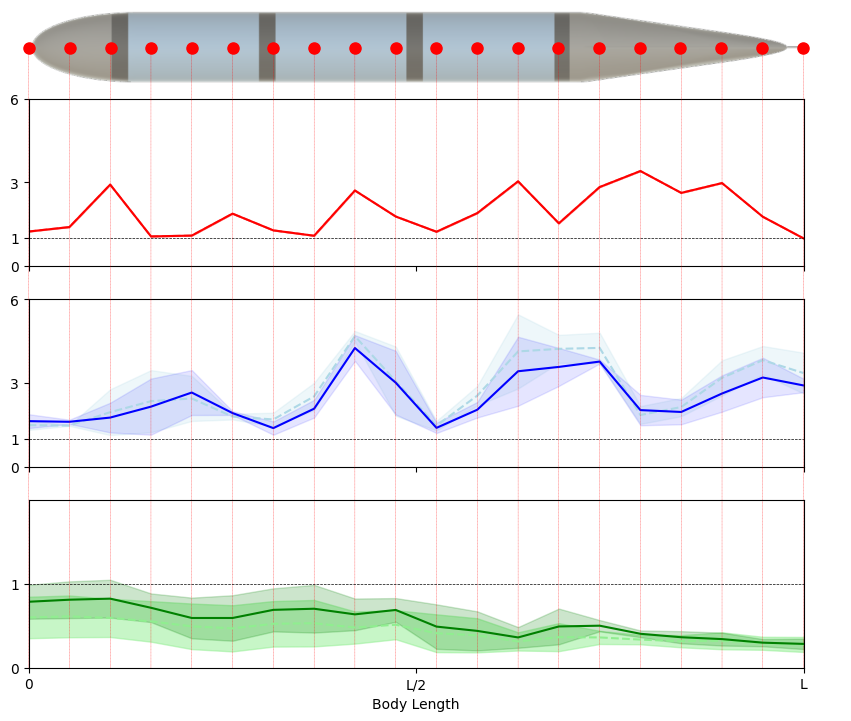

In [38]:
# Plot Training Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all training trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_train_era_equal, label="ERA (Equal Weights)", color='lightcoral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_train_era_equal)), mean_errors_train_era_equal - std_errors_train_era_equal, mean_errors_train_era_equal + std_errors_train_era_equal, color='lightcoral', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_train_era_tail, label="ERA (Tail-Focused Weights)", color='red', linestyle='-')
ax[1].fill_between(range(len(mean_errors_train_era_tail)), mean_errors_train_era_tail - std_errors_train_era_tail, mean_errors_train_era_tail + std_errors_train_era_tail, color='red', alpha=0.2)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_train_dmdc_equal, label="DMDc (Equal Weights)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_train_dmdc_equal)), mean_errors_train_dmdc_equal - std_errors_train_dmdc_equal, mean_errors_train_dmdc_equal + std_errors_train_dmdc_equal, color='lightblue', alpha=0.2, label="Standard Deviation")
ax[2].plot(mean_errors_train_dmdc_tail, label="DMDc (Tail-Focused Weights)", color='blue', linestyle='-')
ax[2].fill_between(range(len(mean_errors_train_dmdc_tail)), mean_errors_train_dmdc_tail - std_errors_train_dmdc_tail, mean_errors_train_dmdc_tail + std_errors_train_dmdc_tail, color='blue', alpha=0.1)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_train_lopinf_equal, label="LOpInf (Equal Weights)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_train_lopinf_equal)), mean_errors_train_lopinf_equal - std_errors_train_lopinf_equal, mean_errors_train_lopinf_equal + std_errors_train_lopinf_equal, color='lightgreen', alpha=0.5, label="Standard Deviation")
ax[3].plot(mean_errors_train_lopinf_tail, label="LOpInf (Tail-Focused Weights)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_train_lopinf_tail)), mean_errors_train_lopinf_tail - std_errors_train_lopinf_tail, mean_errors_train_lopinf_tail + std_errors_train_lopinf_tail, color='green', alpha=0.2)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_TailFocused_Train.svg", format='svg', dpi=1200)



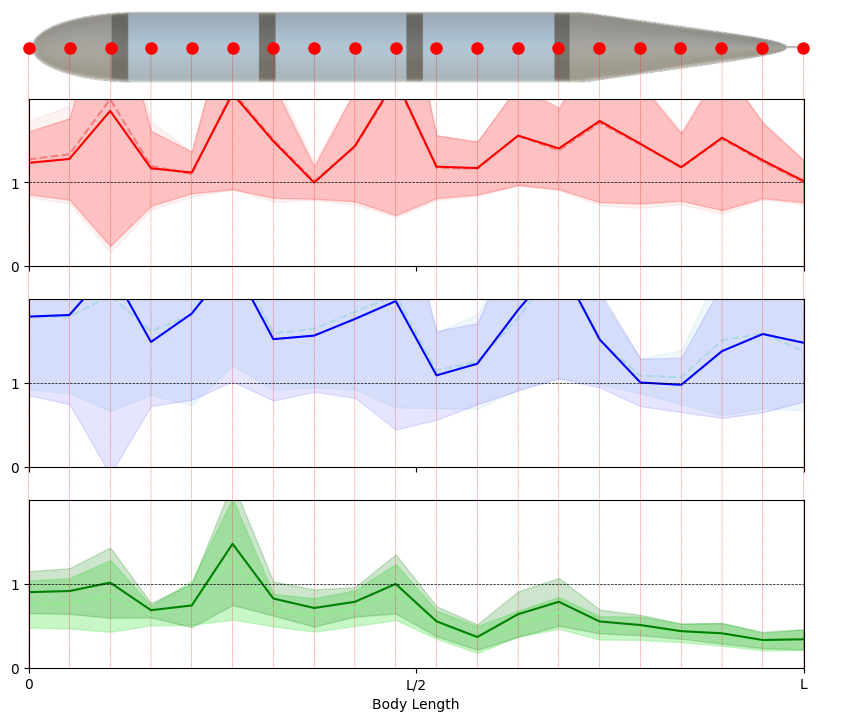

In [39]:
# Plot Test Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all test trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_test_era_equal, label="ERA (Equal Weights)", color='lightcoral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_test_era_equal)), mean_errors_test_era_equal - std_errors_test_era_equal, mean_errors_test_era_equal + std_errors_test_era_equal, color='lightcoral', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_test_era_tail, label="ERA (Tail-Focused Weights)", color='red', linestyle='-')
ax[1].fill_between(range(len(mean_errors_test_era_tail)), mean_errors_test_era_tail - std_errors_test_era_tail, mean_errors_test_era_tail + std_errors_test_era_tail, color='red', alpha=0.2)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 2])
ax[1].set_yticks([0, 1])#, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_test_dmdc_equal, label="DMDc (Equal Weights)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_test_dmdc_equal)), mean_errors_test_dmdc_equal - std_errors_test_dmdc_equal, mean_errors_test_dmdc_equal + std_errors_test_dmdc_equal, color='lightblue', alpha=0.2, label="Standard Deviation")
ax[2].plot(mean_errors_test_dmdc_tail, label="DMDc (Tail-Focused Weights)", color='blue', linestyle='-')
ax[2].fill_between(range(len(mean_errors_test_dmdc_tail)), mean_errors_test_dmdc_tail - std_errors_test_dmdc_tail, mean_errors_test_dmdc_tail + std_errors_test_dmdc_tail, color='blue', alpha=0.1)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 2]) #6
ax[2].set_yticks([0, 1])#, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_test_lopinf_equal, label="LOpInf (Equal Weights)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_test_lopinf_equal)), mean_errors_test_lopinf_equal - std_errors_test_lopinf_equal, mean_errors_test_lopinf_equal + std_errors_test_lopinf_equal, color='lightgreen', alpha=0.5, label="Standard Deviation")
ax[3].plot(mean_errors_test_lopinf_tail, label="LOpInf (Tail-Focused Weights)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_test_lopinf_tail)), mean_errors_test_lopinf_tail - std_errors_test_lopinf_tail, mean_errors_test_lopinf_tail + std_errors_test_lopinf_tail, color='green', alpha=0.2)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_TailFocused_Test.svg", format='svg', dpi=1200)



## Feasible Trajectory Tracking - Tracking Accuracy vs Amount of Training Data for DMDc and LOpInf

In [40]:
# Trial Parameters

lopinf_trial_ids_train_1trial = [467]
lopinf_trial_ids_train_2trial = [454,452]#,428,423] [] 
lopinf_trial_ids_train_3trial = [237,233,214]#,428,423][]
lopinf_trial_ids_test_1trial = [455,456,457,459,461,462,464,466]#,428,423][]
lopinf_trial_ids_test_2trial = [443,444,445,447,449,450,451,453]#,428,423][]
lopinf_trial_ids_test_3trial = [201,203,209,216,219,223,230,236]#,428,423][]
dmdc_trial_ids_train_1trial = [430]#,428,423]
dmdc_trial_ids_train_2trial = [291, 287]#, 267]
dmdc_trial_ids_train_3trial = [442,440,435]#[442, 440, 435]
dmdc_trial_ids_test_1trial = [420, 421, 422, 424, 425, 426, 427, 429]
dmdc_trial_ids_test_2trial = [252, 254, 262, 269, 272, 276, 283, 290]
dmdc_trial_ids_test_3trial = [431,433,434,436,437,438,439,441]#[431, 433, 434, 436, 437, 438, 439, 441]

era_trial_ids_train_1trial = [335]#, 331, 311]
era_trial_ids_test_1trial = [297, 299, 305, 313, 316, 320 ,327, 334]


trial_id = lopinf_trial_ids_train_1trial[0]
timesteps = 500
n = 1

In [41]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

OutputDim: 40, InputDim: 6, x_hatDim: 18


### Relative Error Over Body Length 

#### Training Data Trials

In [42]:
# Initialize array to hold relative errors over all trials 
lopinf_rel_errors_avg_train_1trial = np.zeros((20, len(lopinf_trial_ids_train_1trial)))
lopinf_rel_errors_avg_train_2trial = np.zeros((20, len(lopinf_trial_ids_train_2trial)))
lopinf_rel_errors_avg_train_3trial = np.zeros((20, len(lopinf_trial_ids_train_3trial)))
lopinf_rel_errors_avg_test_1trial = np.zeros((20, len(lopinf_trial_ids_test_1trial)))
lopinf_rel_errors_avg_test_2trial = np.zeros((20, len(lopinf_trial_ids_test_2trial)))
lopinf_rel_errors_avg_test_3trial = np.zeros((20, len(lopinf_trial_ids_test_3trial)))
dmdc_rel_errors_avg_train_1trial = np.zeros((20, len(dmdc_trial_ids_train_1trial)))
dmdc_rel_errors_avg_train_2trial = np.zeros((20, len(dmdc_trial_ids_train_2trial)))
dmdc_rel_errors_avg_train_3trial = np.zeros((20, len(dmdc_trial_ids_train_3trial)))
dmdc_rel_errors_avg_test_1trial = np.zeros((20, len(dmdc_trial_ids_test_1trial)))
dmdc_rel_errors_avg_test_2trial = np.zeros((20, len(dmdc_trial_ids_test_2trial)))
dmdc_rel_errors_avg_test_3trial = np.zeros((20, len(dmdc_trial_ids_test_3trial)))
era_rel_errors_avg_train_1trial = np.zeros((20, len(era_trial_ids_train_1trial)))
era_rel_errors_avg_test_1trial = np.zeros((20, len(era_trial_ids_test_1trial)))
### Calculate statistics for LOpInf trials
# Compute relative errors for each training trial with LOpInf trained on 1 trial 
for trialInd in range(len(lopinf_trial_ids_train_1trial)):
    trial_id = lopinf_trial_ids_train_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with LOpInf trained on 2 trials
for trialInd in range(len(lopinf_trial_ids_train_2trial)):
    trial_id = lopinf_trial_ids_train_2trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_2trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with LOpInf trained on 3 trials
for trialInd in range(len(lopinf_trial_ids_train_3trial)):
    trial_id = lopinf_trial_ids_train_3trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_3trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial with LOpInf trained on 1 trial
for trialInd in range(len(lopinf_trial_ids_test_1trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with LOpInf trained on 2 trials
for trialInd in range(len(lopinf_trial_ids_test_2trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_2trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_2trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with LOpInf trained on 3 trials
for trialInd in range(len(lopinf_trial_ids_test_3trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_3trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_3trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_lopinf_1trial = np.mean(lopinf_rel_errors_avg_train_1trial, axis=1)
mean_errors_train_lopinf_2trial = np.mean(lopinf_rel_errors_avg_train_2trial, axis=1)
mean_errors_train_lopinf_3trial = np.mean(lopinf_rel_errors_avg_train_3trial, axis=1)
std_errors_train_lopinf_1trial = np.std(lopinf_rel_errors_avg_train_1trial, axis=1)
std_errors_train_lopinf_2trial = np.std(lopinf_rel_errors_avg_train_2trial, axis=1)
std_errors_train_lopinf_3trial = np.std(lopinf_rel_errors_avg_train_3trial, axis=1)
mean_errors_test_lopinf_1trial = np.mean(lopinf_rel_errors_avg_test_1trial, axis=1)
mean_errors_test_lopinf_2trial = np.mean(lopinf_rel_errors_avg_test_2trial, axis=1)
mean_errors_test_lopinf_3trial = np.mean(lopinf_rel_errors_avg_test_3trial, axis=1)
std_errors_test_lopinf_1trial = np.std(lopinf_rel_errors_avg_test_1trial, axis=1)
std_errors_test_lopinf_2trial = np.std(lopinf_rel_errors_avg_test_2trial, axis=1)
std_errors_test_lopinf_3trial = np.std(lopinf_rel_errors_avg_test_3trial, axis=1)
### Calculate statistics for DMDc trials
# Compute relative errors for each training trial with DMDc trained on 1 trial
for trialInd in range(len(dmdc_trial_ids_train_1trial)):
    trial_id = dmdc_trial_ids_train_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with DMDc trained on 2 trials
for trialInd in range(len(dmdc_trial_ids_train_2trial)):
    trial_id = dmdc_trial_ids_train_2trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_2trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with DMDc trained on 3 trials
for trialInd in range(len(dmdc_trial_ids_train_3trial)):
    trial_id = dmdc_trial_ids_train_3trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_3trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial with DMDc trained on 1 trial
for trialInd in range(len(dmdc_trial_ids_test_1trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with DMDc trained on 2 trials
for trialInd in range(len(dmdc_trial_ids_test_2trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_2trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_2trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with DMDc trained on 3 trials
for trialInd in range(len(dmdc_trial_ids_test_3trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_3trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_3trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_dmdc_1trial = np.mean(dmdc_rel_errors_avg_train_1trial, axis=1)
mean_errors_train_dmdc_2trial = np.mean(dmdc_rel_errors_avg_train_2trial, axis=1)
mean_errors_train_dmdc_3trial = np.mean(dmdc_rel_errors_avg_train_3trial, axis=1)
std_errors_train_dmdc_1trial = np.std(dmdc_rel_errors_avg_train_1trial, axis=1)
std_errors_train_dmdc_2trial = np.std(dmdc_rel_errors_avg_train_2trial, axis=1)
std_errors_train_dmdc_3trial = np.std(dmdc_rel_errors_avg_train_3trial, axis=1)
mean_errors_test_dmdc_1trial = np.mean(dmdc_rel_errors_avg_test_1trial, axis=1)
mean_errors_test_dmdc_2trial = np.mean(dmdc_rel_errors_avg_test_2trial, axis=1)
mean_errors_test_dmdc_3trial = np.mean(dmdc_rel_errors_avg_test_3trial, axis=1)
std_errors_test_dmdc_1trial = np.std(dmdc_rel_errors_avg_test_1trial, axis=1)
std_errors_test_dmdc_2trial = np.std(dmdc_rel_errors_avg_test_2trial, axis=1)
std_errors_test_dmdc_3trial = np.std(dmdc_rel_errors_avg_test_3trial, axis=1)
### Calculate statistics for ERA trials
# Compute relative errors for each training trial with ERA trained on 1 trial
for trialInd in range(len(era_trial_ids_train_1trial)):
    trial_id = era_trial_ids_train_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial with ERA trained on 1 trial
for trialInd in range(len(era_trial_ids_test_1trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_era_1trial = np.mean(era_rel_errors_avg_train_1trial, axis=1)
mean_errors_test_era_1trial = np.mean(era_rel_errors_avg_test_1trial, axis=1)
std_errors_train_era_1trial = np.std(era_rel_errors_avg_train_1trial, axis=1)
std_errors_test_era_1trial = np.std(era_rel_errors_avg_test_1trial, axis=1)

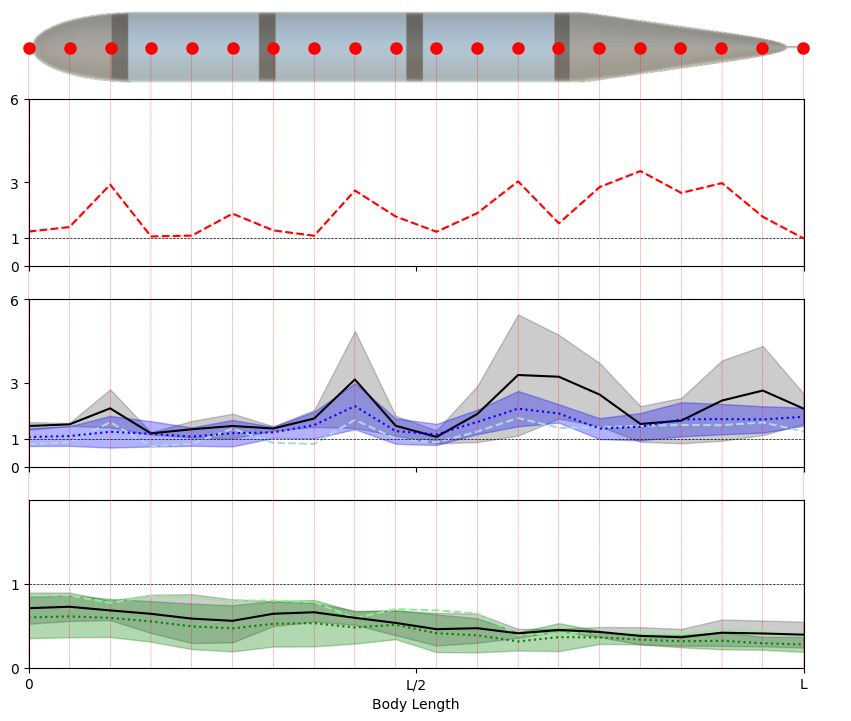

In [43]:
# Plot Training Errors for LOpInf, DMDc, and ERA with different amounts of training trials
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all training trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_train_era_1trial, label="ERA (1 Trial)", color='red', linestyle='--')
ax[1].fill_between(range(len(mean_errors_train_era_1trial)), mean_errors_train_era_1trial - std_errors_train_era_1trial, mean_errors_train_era_1trial + std_errors_train_era_1trial, color='red', alpha=0.1)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_train_dmdc_1trial, label="DMDc (1 Trial)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_train_dmdc_1trial)), mean_errors_train_dmdc_1trial - std_errors_train_dmdc_1trial, mean_errors_train_dmdc_1trial + std_errors_train_dmdc_1trial, color='lightblue', alpha=0.1)
ax[2].plot(mean_errors_train_dmdc_2trial, label="DMDc (2 Trials)", color='black', linestyle='-')
ax[2].fill_between(range(len(mean_errors_train_dmdc_2trial)), mean_errors_train_dmdc_2trial - std_errors_train_dmdc_2trial, mean_errors_train_dmdc_2trial + std_errors_train_dmdc_2trial, color='black', alpha=0.2)
ax[2].plot(mean_errors_train_dmdc_3trial, label="DMDc (3 Trials)", color='blue', linestyle=':')
ax[2].fill_between(range(len(mean_errors_train_dmdc_3trial)), mean_errors_train_dmdc_3trial - std_errors_train_dmdc_3trial, mean_errors_train_dmdc_3trial + std_errors_train_dmdc_3trial, color='blue', alpha=0.3)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_train_lopinf_1trial, label="LOpInf (1 Trial)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_train_lopinf_1trial)), mean_errors_train_lopinf_1trial - std_errors_train_lopinf_1trial, mean_errors_train_lopinf_1trial + std_errors_train_lopinf_1trial, color='lightgreen', alpha=0.1, label="Standard Deviation")
ax[3].plot(mean_errors_train_lopinf_2trial, label="LOpInf (2 Trials)", color='black', linestyle='-')
ax[3].fill_between(range(len(mean_errors_train_lopinf_2trial)), mean_errors_train_lopinf_2trial - std_errors_train_lopinf_2trial, mean_errors_train_lopinf_2trial + std_errors_train_lopinf_2trial, color='black', alpha=0.2)
ax[3].plot(mean_errors_train_lopinf_3trial, label="LOpInf (3 Trials)", color='green', linestyle=':')
ax[3].fill_between(range(len(mean_errors_train_lopinf_3trial)), mean_errors_train_lopinf_3trial - std_errors_train_lopinf_3trial, mean_errors_train_lopinf_3trial + std_errors_train_lopinf_3trial, color='green', alpha=0.3)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_Train_NumTrainingTrials.svg", format='svg', dpi=1200)



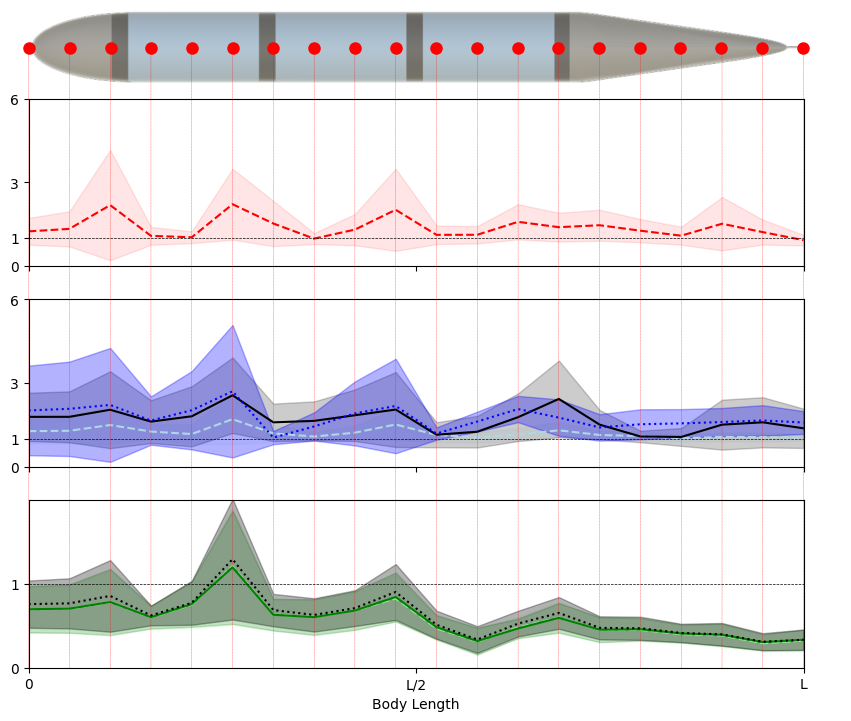

In [44]:
# Plot Test Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all test trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_test_era_1trial, label="ERA (1 Trial)", color='red', linestyle='--')
ax[1].fill_between(range(len(mean_errors_test_era_1trial)), mean_errors_test_era_1trial - std_errors_test_era_1trial, mean_errors_test_era_1trial + std_errors_test_era_1trial, color='red', alpha=0.1)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Plot tracking errors over all test trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_test_dmdc_1trial, label="DMDc (1 Trial)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_test_dmdc_1trial)), mean_errors_test_dmdc_1trial - std_errors_test_dmdc_1trial, mean_errors_test_dmdc_1trial + std_errors_test_dmdc_1trial, color='lightblue', alpha=0.1)
ax[2].plot(mean_errors_test_dmdc_2trial, label="DMDc (2 Trials)", color='black', linestyle='-')
ax[2].fill_between(range(len(mean_errors_test_dmdc_2trial)), mean_errors_test_dmdc_2trial - std_errors_test_dmdc_2trial, mean_errors_test_dmdc_2trial + std_errors_test_dmdc_2trial, color='black', alpha=0.2)
ax[2].plot(mean_errors_test_dmdc_3trial, label="DMDc (3 Trials)", color='blue', linestyle=':')
ax[2].fill_between(range(len(mean_errors_test_dmdc_3trial)), mean_errors_test_dmdc_3trial - std_errors_test_dmdc_3trial, mean_errors_test_dmdc_3trial + std_errors_test_dmdc_3trial, color='blue', alpha=0.3)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Plot tracking errors over all test trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_test_lopinf_1trial, label="LOpInf (1 Trial)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_test_lopinf_1trial)), mean_errors_test_lopinf_1trial - std_errors_test_lopinf_1trial, mean_errors_test_lopinf_1trial + std_errors_test_lopinf_1trial, color='lightgreen', alpha=0.1, label="Standard Deviation")
ax[3].plot(mean_errors_test_lopinf_2trial, label="LOpInf (2 Trials)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_test_lopinf_2trial)), mean_errors_test_lopinf_2trial - std_errors_test_lopinf_2trial, mean_errors_test_lopinf_2trial + std_errors_test_lopinf_2trial, color='green', alpha=0.2)
ax[3].plot(mean_errors_test_lopinf_3trial, label="LOpInf (3 Trials)", color='black', linestyle=':')
ax[3].fill_between(range(len(mean_errors_test_lopinf_3trial)), mean_errors_test_lopinf_3trial - std_errors_test_lopinf_3trial, mean_errors_test_lopinf_3trial + std_errors_test_lopinf_3trial, color='black', alpha=0.3)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)

# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_Test_NumTrainingTrials.svg", format='svg', dpi=1200)

## Feasible Trajectory Tracking - Tracking Accuracy vs Dimension of ROM

In [50]:
# Trial Parameters

lopinf_trial_ids_train_2dim =  [479]
lopinf_trial_ids_train_10dim = [490]
lopinf_trial_ids_train_18dim = [467]
lopinf_trial_ids_test_2dim =   [468,469,470,472,473,474,476,478]
lopinf_trial_ids_test_10dim =  [480,481,482,484,485,486,487,489]
lopinf_trial_ids_test_18dim =  [455,456,457,459,461,462,464,466]

dmdc_trial_ids_train_2dim =  [525]
dmdc_trial_ids_train_10dim = [538]
dmdc_trial_ids_train_18dim = [430]
dmdc_trial_ids_test_2dim =   [513, 515, 516, 518, 519, 520, 521, 523]
dmdc_trial_ids_test_10dim =  [526, 528, 529, 531, 533, 534, 535,537] 
dmdc_trial_ids_test_18dim =  [420, 421, 422, 424, 425, 426, 427, 429]

era_trial_ids_train_2dim =  [501]
era_trial_ids_train_10dim = [512]
era_trial_ids_train_18dim = [335]
era_trial_ids_test_2dim =   [491, 492, 493, 495, 496, 497, 498, 500]
era_trial_ids_test_10dim =  [502, 503, 504, 506, 507, 508, 509, 511]
era_trial_ids_test_18dim =  [297, 299, 305, 313, 316, 320, 327, 334]


trial_id = lopinf_trial_ids_train_2dim[0]
timesteps = 500
n = 1

In [51]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

OutputDim: 40, InputDim: 6, x_hatDim: 2


### Relative Error Over Body Length 

#### Training Data Trials

In [52]:
# Initialize array to hold relative errors over all trials 
lopinf_rel_errors_avg_train_2dim  = np.zeros((20, len(lopinf_trial_ids_train_2dim )))
lopinf_rel_errors_avg_train_10dim = np.zeros((20, len(lopinf_trial_ids_train_10dim)))
lopinf_rel_errors_avg_train_18dim = np.zeros((20, len(lopinf_trial_ids_train_18dim)))
lopinf_rel_errors_avg_test_2dim  = np.zeros((20, len(lopinf_trial_ids_test_2dim )))
lopinf_rel_errors_avg_test_10dim = np.zeros((20, len(lopinf_trial_ids_test_10dim)))
lopinf_rel_errors_avg_test_18dim = np.zeros((20, len(lopinf_trial_ids_test_18dim)))
dmdc_rel_errors_avg_train_2dim  = np.zeros((20, len(dmdc_trial_ids_train_2dim )))
dmdc_rel_errors_avg_train_10dim = np.zeros((20, len(dmdc_trial_ids_train_10dim)))
dmdc_rel_errors_avg_train_18dim = np.zeros((20, len(dmdc_trial_ids_train_18dim)))
dmdc_rel_errors_avg_test_2dim  = np.zeros((20, len(dmdc_trial_ids_test_2dim )))
dmdc_rel_errors_avg_test_10dim = np.zeros((20, len(dmdc_trial_ids_test_10dim)))
dmdc_rel_errors_avg_test_18dim = np.zeros((20, len(dmdc_trial_ids_test_18dim)))
era_rel_errors_avg_train_2dim  = np.zeros((20, len(era_trial_ids_train_2dim )))
era_rel_errors_avg_train_10dim = np.zeros((20, len(era_trial_ids_train_10dim)))
era_rel_errors_avg_train_18dim = np.zeros((20, len(era_trial_ids_train_18dim)))
era_rel_errors_avg_test_2dim  = np.zeros((20, len(era_trial_ids_test_2dim )))
era_rel_errors_avg_test_10dim = np.zeros((20, len(era_trial_ids_test_10dim)))
era_rel_errors_avg_test_18dim = np.zeros((20, len(era_trial_ids_test_18dim)))
### Calculate statistics for LOpInf trials
# Compute relative errors for each training trial with LOpInf with state dimension 2 
for trialInd in range(len(lopinf_trial_ids_train_2dim)):
    trial_id = lopinf_trial_ids_train_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with LOpInf with state dimension 10
for trialInd in range(len(lopinf_trial_ids_train_10dim)):
    trial_id = lopinf_trial_ids_train_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with LOpInf with state dimension 18
for trialInd in range(len(lopinf_trial_ids_train_18dim)):
    trial_id = lopinf_trial_ids_train_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial with LOpInf with state dimension 2
for trialInd in range(len(lopinf_trial_ids_test_2dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_2dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with LOpInf with state dimension 10
for trialInd in range(len(lopinf_trial_ids_test_10dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with LOpInf with state dimension 18
for trialInd in range(len(lopinf_trial_ids_test_18dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_lopinf_2dim = np.mean(lopinf_rel_errors_avg_train_2dim, axis=1)
mean_errors_train_lopinf_10dim = np.mean(lopinf_rel_errors_avg_train_10dim, axis=1)
mean_errors_train_lopinf_18dim = np.mean(lopinf_rel_errors_avg_train_18dim, axis=1)
std_errors_train_lopinf_2dim = np.std(lopinf_rel_errors_avg_train_2dim, axis=1)
std_errors_train_lopinf_10dim = np.std(lopinf_rel_errors_avg_train_10dim, axis=1)
std_errors_train_lopinf_18dim = np.std(lopinf_rel_errors_avg_train_18dim, axis=1)
mean_errors_test_lopinf_2dim = np.mean(lopinf_rel_errors_avg_test_2dim, axis=1)
mean_errors_test_lopinf_10dim = np.mean(lopinf_rel_errors_avg_test_10dim, axis=1)
mean_errors_test_lopinf_18dim = np.mean(lopinf_rel_errors_avg_test_18dim, axis=1)
std_errors_test_lopinf_2dim = np.std(lopinf_rel_errors_avg_test_2dim, axis=1)
std_errors_test_lopinf_10dim = np.std(lopinf_rel_errors_avg_test_10dim, axis=1)
std_errors_test_lopinf_18dim = np.std(lopinf_rel_errors_avg_test_18dim, axis=1)
### Calculate statistics for DMDc trials
# Compute relative errors for each training trial with DMDc trained on 2 trials
for trialInd in range(len(dmdc_trial_ids_train_2dim)):
    trial_id = dmdc_trial_ids_train_2dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with DMDc trained on 10 trials
for trialInd in range(len(dmdc_trial_ids_train_10dim)):
    trial_id = dmdc_trial_ids_train_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with DMDc trained on 18 trials
for trialInd in range(len(dmdc_trial_ids_train_18dim)):
    trial_id = dmdc_trial_ids_train_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial with DMDc trained on 2 trials
for trialInd in range(len(dmdc_trial_ids_test_2dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_2dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with DMDc trained on 10 trials
for trialInd in range(len(dmdc_trial_ids_test_10dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with DMDc trained on 18 trials
for trialInd in range(len(dmdc_trial_ids_test_18dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_dmdc_2dim = np.mean(dmdc_rel_errors_avg_train_2dim, axis=1)
mean_errors_train_dmdc_10dim = np.mean(dmdc_rel_errors_avg_train_10dim, axis=1)
mean_errors_train_dmdc_18dim = np.mean(dmdc_rel_errors_avg_train_18dim, axis=1)
std_errors_train_dmdc_2dim = np.std(dmdc_rel_errors_avg_train_2dim, axis=1)
std_errors_train_dmdc_10dim = np.std(dmdc_rel_errors_avg_train_10dim, axis=1)
std_errors_train_dmdc_18dim = np.std(dmdc_rel_errors_avg_train_18dim, axis=1)
mean_errors_test_dmdc_2dim = np.mean(dmdc_rel_errors_avg_test_2dim, axis=1)
mean_errors_test_dmdc_10dim = np.mean(dmdc_rel_errors_avg_test_10dim, axis=1)
mean_errors_test_dmdc_18dim = np.mean(dmdc_rel_errors_avg_test_18dim, axis=1)
std_errors_test_dmdc_2dim = np.std(dmdc_rel_errors_avg_test_2dim, axis=1)
std_errors_test_dmdc_10dim = np.std(dmdc_rel_errors_avg_test_10dim, axis=1)
std_errors_test_dmdc_18dim = np.std(dmdc_rel_errors_avg_test_18dim, axis=1)
### Calculate statistics for ERA trials
# Compute relative errors for each training trial with ERA trained on 2 trials
for trialInd in range(len(era_trial_ids_train_2dim)):
    trial_id = era_trial_ids_train_2dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with ERA trained on 10 trials
for trialInd in range(len(era_trial_ids_train_10dim)):
    trial_id = era_trial_ids_train_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with ERA trained on 18 trials
for trialInd in range(len(era_trial_ids_train_18dim)):
    trial_id = era_trial_ids_train_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each test trial with ERA trained on 2 trials
for trialInd in range(len(era_trial_ids_test_2dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_2dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with ERA trained on 10 trials
for trialInd in range(len(era_trial_ids_test_10dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with ERA trained on 18 trials
for trialInd in range(len(era_trial_ids_test_18dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
mean_errors_train_era_2dim = np.mean(era_rel_errors_avg_train_2dim, axis=1)
mean_errors_train_era_10dim = np.mean(era_rel_errors_avg_train_10dim, axis=1)
mean_errors_train_era_18dim = np.mean(era_rel_errors_avg_train_18dim, axis=1)
std_errors_train_era_2dim = np.std(era_rel_errors_avg_train_2dim, axis=1)
std_errors_train_era_10dim = np.std(era_rel_errors_avg_train_10dim, axis=1)
std_errors_train_era_18dim = np.std(era_rel_errors_avg_train_18dim, axis=1)
mean_errors_test_era_2dim = np.mean(era_rel_errors_avg_test_2dim, axis=1)
mean_errors_test_era_10dim = np.mean(era_rel_errors_avg_test_10dim, axis=1)
mean_errors_test_era_18dim = np.mean(era_rel_errors_avg_test_18dim, axis=1)
std_errors_test_era_2dim = np.std(era_rel_errors_avg_test_2dim, axis=1)
std_errors_test_era_10dim = np.std(era_rel_errors_avg_test_10dim, axis=1)
std_errors_test_era_18dim = np.std(era_rel_errors_avg_test_18dim, axis=1)



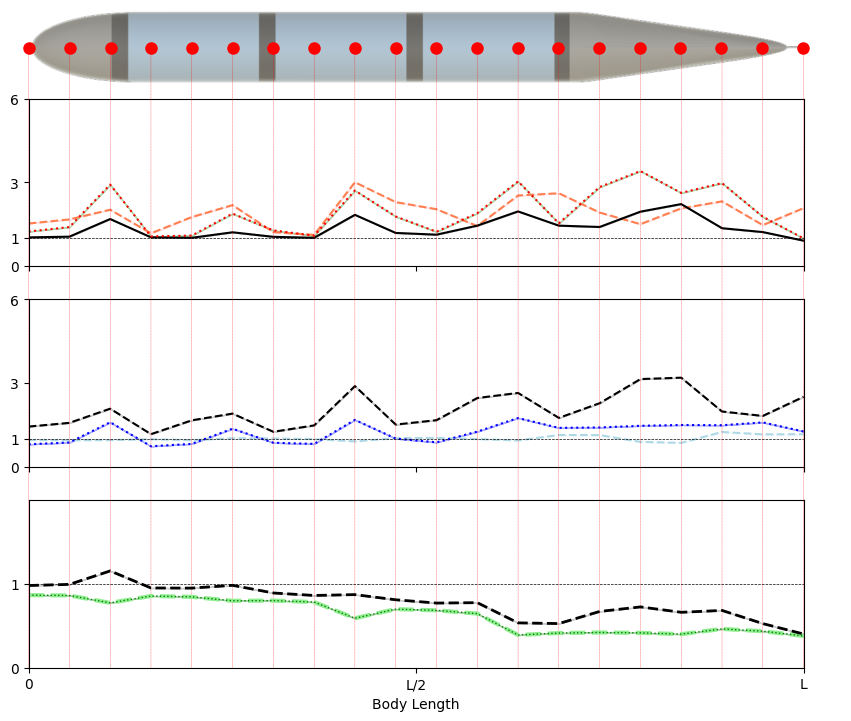

In [55]:
# Plot Training Errors for LOpInf, DMDc, and ERA with different amounts of training trials
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all training trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_train_era_2dim, label="ERA (2 Dim)", color='coral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_train_era_2dim)), mean_errors_train_era_2dim - std_errors_train_era_2dim, mean_errors_train_era_2dim + std_errors_train_era_2dim, color='red', alpha=0.1)
ax[1].plot(mean_errors_train_era_10dim, label="ERA (10 Dim)", color='black', linestyle='-')
ax[1].fill_between(range(len(mean_errors_train_era_10dim)), mean_errors_train_era_10dim - std_errors_train_era_10dim, mean_errors_train_era_10dim + std_errors_train_era_10dim, color='black', alpha=0.2)
ax[1].plot(mean_errors_train_era_18dim, label="ERA (18 Dim)", color='red', linestyle=':')
ax[1].fill_between(range(len(mean_errors_train_era_18dim)), mean_errors_train_era_18dim - std_errors_train_era_18dim, mean_errors_train_era_18dim + std_errors_train_era_18dim, color='green', alpha=0.3)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_train_dmdc_2dim, label="DMDc (2 Dim)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_train_dmdc_2dim)), mean_errors_train_dmdc_2dim - std_errors_train_dmdc_2dim, mean_errors_train_dmdc_2dim + std_errors_train_dmdc_2dim, color='lightblue', alpha=0.1)
ax[2].plot(mean_errors_train_dmdc_10dim, label="DMDc (10 Dim)", color='black', linestyle='--')
ax[2].fill_between(range(len(mean_errors_train_dmdc_10dim)), mean_errors_train_dmdc_10dim - std_errors_train_dmdc_10dim, mean_errors_train_dmdc_10dim + std_errors_train_dmdc_10dim, color='black', alpha=0.2)
ax[2].plot(mean_errors_train_dmdc_18dim, label="DMDc (18 Dim)", color='blue', linestyle=':')
ax[2].fill_between(range(len(mean_errors_train_dmdc_18dim)), mean_errors_train_dmdc_18dim - std_errors_train_dmdc_18dim, mean_errors_train_dmdc_18dim + std_errors_train_dmdc_18dim, color='blue', alpha=0.3)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Plot tracking errors over all training trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_train_lopinf_2dim, label="LOpInf (2 Dim)", color='lightgreen', linestyle='--',linewidth=3)
ax[3].fill_between(range(len(mean_errors_train_lopinf_2dim)), mean_errors_train_lopinf_2dim - std_errors_train_lopinf_2dim, mean_errors_train_lopinf_2dim + std_errors_train_lopinf_2dim, color='lightgreen', alpha=0.1)
ax[3].plot(mean_errors_train_lopinf_10dim, label="LOpInf (10 Dim)", color='black', linestyle='--', linewidth=2)
ax[3].fill_between(range(len(mean_errors_train_lopinf_10dim)), mean_errors_train_lopinf_10dim - std_errors_train_lopinf_10dim, mean_errors_train_lopinf_10dim + std_errors_train_lopinf_10dim, color='black', alpha=0.2)
ax[3].plot(mean_errors_train_lopinf_18dim, label="LOpInf (18 Dim)", color='green', linestyle=':', linewidth=1)
ax[3].fill_between(range(len(mean_errors_train_lopinf_18dim)), mean_errors_train_lopinf_18dim - std_errors_train_lopinf_18dim, mean_errors_train_lopinf_18dim + std_errors_train_lopinf_18dim, color='green', alpha=0.3)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_Train_NumTrainingTrials.svg", format='svg', dpi=1200)



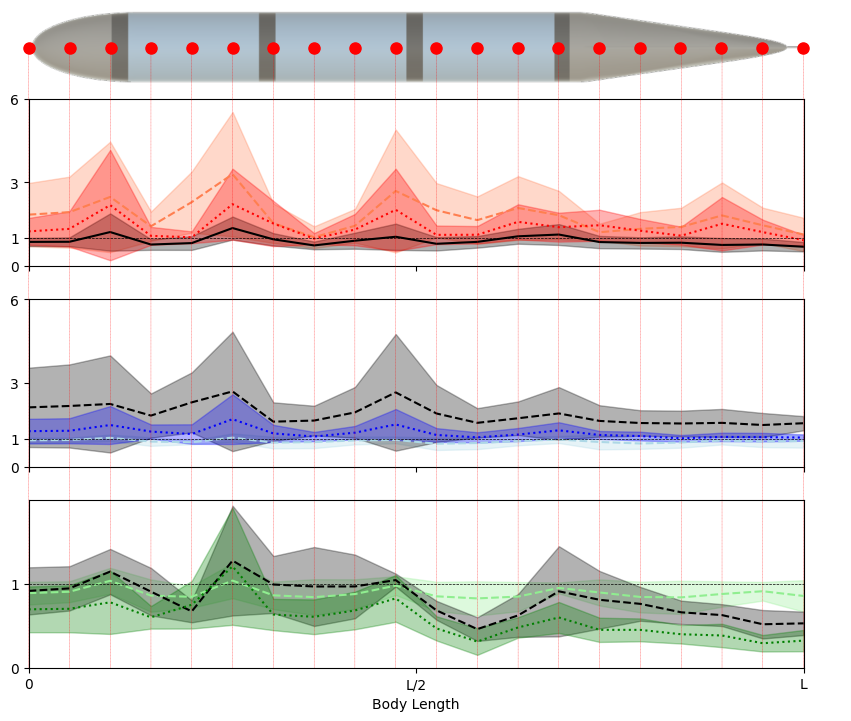

In [54]:
# Plot Training Errors for LOpInf, DMDc, and ERA with different amounts of training trials
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all test trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_test_era_2dim, label="ERA (2 Dim)", color='coral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_test_era_2dim)), mean_errors_test_era_2dim - std_errors_test_era_2dim, mean_errors_test_era_2dim + std_errors_test_era_2dim, color='coral', alpha=0.3)
ax[1].plot(mean_errors_test_era_10dim, label="ERA (10 Dim)", color='black', linestyle='-')
ax[1].fill_between(range(len(mean_errors_test_era_10dim)), mean_errors_test_era_10dim - std_errors_test_era_10dim, mean_errors_test_era_10dim + std_errors_test_era_10dim, color='black', alpha=0.3)
ax[1].plot(mean_errors_test_era_18dim, label="ERA (18 Dim)", color='red', linestyle=':')
ax[1].fill_between(range(len(mean_errors_test_era_18dim)), mean_errors_test_era_18dim - std_errors_test_era_18dim, mean_errors_test_era_18dim + std_errors_test_era_18dim, color='red', alpha=0.3)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_test_dmdc_2dim, label="DMDc (2 Dim)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_test_dmdc_2dim)), mean_errors_test_dmdc_2dim - std_errors_test_dmdc_2dim, mean_errors_test_dmdc_2dim + std_errors_test_dmdc_2dim, color='lightblue', alpha=0.3)
ax[2].plot(mean_errors_test_dmdc_10dim, label="DMDc (10 Dim)", color='black', linestyle='--')
ax[2].fill_between(range(len(mean_errors_test_dmdc_10dim)), mean_errors_test_dmdc_10dim - std_errors_test_dmdc_10dim, mean_errors_test_dmdc_10dim + std_errors_test_dmdc_10dim, color='black', alpha=0.3)
ax[2].plot(mean_errors_test_dmdc_18dim, label="DMDc (18 Dim)", color='blue', linestyle=':')
ax[2].fill_between(range(len(mean_errors_test_dmdc_18dim)), mean_errors_test_dmdc_18dim - std_errors_test_dmdc_18dim, mean_errors_test_dmdc_18dim + std_errors_test_dmdc_18dim, color='blue', alpha=0.3)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Plot tracking errors over all training trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_test_lopinf_2dim, label="LOpInf (2 Dim)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_test_lopinf_2dim)), mean_errors_test_lopinf_2dim - std_errors_test_lopinf_2dim, mean_errors_test_lopinf_2dim + std_errors_test_lopinf_2dim, color='lightgreen', alpha=0.3)
ax[3].plot(mean_errors_test_lopinf_10dim, label="LOpInf (10 Dim)", color='black', linestyle='--')
ax[3].fill_between(range(len(mean_errors_test_lopinf_10dim)), mean_errors_test_lopinf_10dim - std_errors_test_lopinf_10dim, mean_errors_test_lopinf_10dim + std_errors_test_lopinf_10dim, color='black', alpha=0.3)
ax[3].plot(mean_errors_test_lopinf_18dim, label="LOpInf (18 Dim)", color='green', linestyle=':')
ax[3].fill_between(range(len(mean_errors_test_lopinf_18dim)), mean_errors_test_lopinf_18dim - std_errors_test_lopinf_18dim, mean_errors_test_lopinf_18dim + std_errors_test_lopinf_18dim, color='green', alpha=0.3)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)

# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_Test_NumTrainingTrials.svg", format='svg', dpi=1200)


## Bioinspired Trajectory Tracking

In [ ]:
# Trial Parameters
bioinspiredParamsDict = {"model":['dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','era','era','era','era','era','era','era','era','era','era','era','era'],
                         "amplitude": [10,10,10,10,10,10,30,30,30,30,30,30,10,10,10,10,10,10,30,30,30,30,30,30,10,10,10,10,10,10,30,30,30,30,30,30],
                         "freq": [0.5,0.5,0.5,1,1,1,0.5,0.5,0.5,1,1,1,0.5,0.5,0.5,1,1,1,0.5,0.5,0.5,1,1,1,0.5,0.5,0.5,1,1,1,0.5,0.5,0.5,1,1,1],
                         "wavenumber": [0.5,1.0,1.5,0.5,1.0,1.5,0.5,1.0,1.5,0.5,1.0,1.5,0.5,1.0,1.5,0.5,1.0,1.5,0.5,1.0,1.5,0.5,1.0,1.5,0.5,1.0,1.5,0.5,1.0,1.5,0.5,1.0,1.5,0.5,1.0,1.5],
                         "trial_id": [539,540,541,542,543,544,545,546,549,550,551,552,553,554,555,556,557,558,559,560,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577]
                         }
# Form dataframe
bioinspiredParams = pd.DataFrame(bioinspiredParamsDict)


trial_id = bioinspiredParams['trial_id'].values[0]
timesteps = 1000
n = 1

In [ ]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

### Compute Errors and Store

### Plot